In [1]:
import tensorflow as tf
# from tensorboard.plugins.hparams import api as hp
from tensorflow import keras

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [7]:
import warnings
warnings.filterwarnings('ignore')

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
ratings = pd.read_pickle("./Data/random_selection_longform_20plus_ratings.pkl")
user_stats = pd.read_pickle("./Data/moderate_user_stats.pkl")

In [5]:
def center_ratings(ratings_df, users_df):
    
    dfs = []
    for user in ratings_df.user_id.unique():
        temp_df = ratings_df[ratings_df.user_id==user]
        temp_df['centered_ratings'] = temp_df['rating_score'].sub(users_df.at[user, 'mean_score'])
        temp_df['old_index'] = ratings_df[ratings_df.user_id==user].index
        dfs.append(temp_df)
    
    new_df = pd.concat(dfs, axis=0)
    return new_df

In [8]:
ratings_centered = center_ratings(ratings, user_stats)

In [10]:
ratings_centered.head()

,movie_id,rating_score,user_id,centered_ratings,old_index
0,174,5,94961724,0.414062,0
31123,180,4,94961724,-0.585938,31123
37257,215,5,94961724,0.414062,37257
66146,894,5,94961724,0.414062,66146
123364,3439,4,94961724,-0.585938,123364


In [ ]:
ratings_centered.sort_index(inplace=True)
ratings_centered.reset_index(drop=True, inplace=True)
del ratings_centered['old_index']

In [28]:
ratings_centered

,movie_id,rating_score,user_id,centered_ratings
0,174,5,94961724,0.414062
1,132529,3,73906492,-1.151515
2,104861,4,7147498,-0.244681
3,1819,4,23802188,0.398467
4,1702,3,1651575,-0.375000
...,...,...,...,...
1916184,196948,5,29207485,0.579832
1916185,1728,3,38184030,-0.542484
1916186,1773,4,45211681,-0.409449
1916187,8416,4,35161874,-0.554795


In [29]:
user_enc = LabelEncoder()
ratings_centered['user'] = user_enc.fit_transform(ratings_centered['user_id'].values)
n_users = ratings_centered['user'].nunique()

item_enc = LabelEncoder()
ratings_centered['movie'] = item_enc.fit_transform(ratings_centered['movie_id'].values)
n_movies = ratings_centered['movie'].nunique()

nmovie_id = ratings_centered.movie_id.nunique()
nuser_id = ratings_centered.user_id.nunique()

n_users, n_movies

(73222, 45164)

In [36]:
pd.to_pickle(ratings_centered, "./Data/centered_ratings_20plus_ratings.pkl")

In [31]:
X_train, X_test = train_test_split(ratings_centered[['movie', 'user', 'centered_ratings']], test_size=0.3, random_state=42)

In [32]:
len(X_train)

1341332

In [33]:
l2_1 = keras.regularizers.l2(.1)
l2_01 = 'l2'
l2_001 = keras.regularizers.l2(.001)

In [34]:
HP_NUM_UNITS = [32, 64, 128, 256]
HP_DROPOUT = [.3, .4, .5]
HP_LEARNING_RATE = [.001, .01, .1]
HP_REGULARIZER = [l2_1, 'l2', l2_001]


In [38]:
def train_test_model(hparams):
    
    input_movies = keras.layers.Input(shape=[1])
    embed_movies = keras.layers.Embedding(nmovie_id+1, 15)(input_movies)
    movies_out = keras.layers.Flatten()(embed_movies)

    input_users = keras.layers.Input(shape=[1])
    embed_users = keras.layers.Embedding(nuser_id+1, 15)(input_users)
    users_out = keras.layers.Flatten()(embed_users)

    conc_layer = keras.layers.Concatenate()([movies_out, users_out])
    
    dense1 = keras.layers.Dense(hparams['HP_NUM_UNITS'], 
                           activation='relu', 
                           kernel_regularizer=hparams['HP_REGULARIZER'])(conc_layer)
    
    dropout = keras.layers.Dropout(rate=hparams['HP_DROPOUT'], seed=42)(dense1)
    
    dense2 = keras.layers.Dense(hparams['HP_NUM_UNITS'], 
                           activation='relu', 
                           kernel_regularizer=hparams['HP_REGULARIZER'])(dropout)
    
    x_out = keras.layers.Dense(1, 
                               activation='relu',
                              kernel_regularizer=hparams['HP_REGULARIZER'])(dense2)

    model = keras.Model([input_movies, input_users], x_out)
    
    opt = tf.optimizers.Adam(learning_rate=hparams['HP_LEARNING_RATE'])
    model.compile(optimizer=opt, loss='mean_squared_error', metrics = keras.metrics.RootMeanSquaredError())
    
    hist = model.fit([X_train.movie, X_train.user], 
                 X_train.centered_ratings,  
                 batch_size=len(X_train), epochs=100, validation_split=.2)

    return hist

In [39]:
run_history = {}

session_num = 0

for num_units in HP_NUM_UNITS:
    for dropout_rate in HP_DROPOUT:
        for learning_rate in HP_LEARNING_RATE:
            for regularization in HP_REGULARIZER:
                hparams = {
                'HP_NUM_UNITS': num_units,
                'HP_DROPOUT': dropout_rate,
                'HP_LEARNING_RATE': learning_rate,
                'HP_REGULARIZER': regularization,
                }
                
                run_name = "run-{}".format(session_num)
                print("----Starting trial: {}".format(run_name))
                print(hparams)
                
                output = train_test_model(hparams,)
                run_history[run_name] = {
                    'params': hparams,
                    'output': output,
                }
                session_num += 1

----Starting trial: run-0
{'HP_NUM_UNITS': 32, 'HP_DROPOUT': 0.3, 'HP_LEARNING_RATE': 0.001, 'HP_REGULARIZER': <tensorflow.python.keras.regularizers.L2 object at 0x7f8fea9f6e50>}
Epoch 1/100
1/1 [==============================] - 4s 4s/step - loss: 7.4404 - root_mean_squared_error: 0.9072 - val_loss: 7.3783 - val_root_mean_squared_error: 0.9079
Epoch 2/100
1/1 [==============================] - 1s 1s/step - loss: 7.3768 - root_mean_squared_error: 0.9071 - val_loss: 7.3153 - val_root_mean_squared_error: 0.9078
Epoch 3/100
1/1 [==============================] - 1s 1s/step - loss: 7.3137 - root_mean_squared_error: 0.9070 - val_loss: 7.2528 - val_root_mean_squared_error: 0.9078
Epoch 4/100
1/1 [==============================] - 1s 1s/step - loss: 7.2511 - root_mean_squared_error: 0.9069 - val_loss: 7.1906 - val_root_mean_squared_error: 0.9077
Epoch 5/100
1/1 [==============================] - 1s 1s/step - loss: 7.1889 - root_mean_squared_error: 0.9068 - val_loss: 7.1288 - val_root_mean_squ

Epoch 48/100
1/1 [==============================] - 1s 1s/step - loss: 4.9221 - root_mean_squared_error: 0.8925 - val_loss: 4.8849 - val_root_mean_squared_error: 0.8955
Epoch 49/100
1/1 [==============================] - 1s 1s/step - loss: 4.8791 - root_mean_squared_error: 0.8923 - val_loss: 4.8425 - val_root_mean_squared_error: 0.8953
Epoch 50/100
1/1 [==============================] - 1s 1s/step - loss: 4.8367 - root_mean_squared_error: 0.8920 - val_loss: 4.8006 - val_root_mean_squared_error: 0.8951
Epoch 51/100
1/1 [==============================] - 1s 1s/step - loss: 4.7946 - root_mean_squared_error: 0.8918 - val_loss: 4.7590 - val_root_mean_squared_error: 0.8949
Epoch 52/100
1/1 [==============================] - 1s 977ms/step - loss: 4.7529 - root_mean_squared_error: 0.8915 - val_loss: 4.7179 - val_root_mean_squared_error: 0.8947
Epoch 53/100
1/1 [==============================] - 1s 1s/step - loss: 4.7118 - root_mean_squared_error: 0.8913 - val_loss: 4.6771 - val_root_mean_squar

Epoch 96/100
1/1 [==============================] - 1s 935ms/step - loss: 3.2756 - root_mean_squared_error: 0.8868 - val_loss: 3.2580 - val_root_mean_squared_error: 0.8918
Epoch 97/100
1/1 [==============================] - 1s 943ms/step - loss: 3.2489 - root_mean_squared_error: 0.8867 - val_loss: 3.2317 - val_root_mean_squared_error: 0.8918
Epoch 98/100
1/1 [==============================] - 1s 935ms/step - loss: 3.2226 - root_mean_squared_error: 0.8867 - val_loss: 3.2056 - val_root_mean_squared_error: 0.8918
Epoch 99/100
1/1 [==============================] - 1s 1s/step - loss: 3.1966 - root_mean_squared_error: 0.8867 - val_loss: 3.1798 - val_root_mean_squared_error: 0.8918
Epoch 100/100
1/1 [==============================] - 1s 1s/step - loss: 3.1708 - root_mean_squared_error: 0.8867 - val_loss: 3.1543 - val_root_mean_squared_error: 0.8918
----Starting trial: run-1
{'HP_NUM_UNITS': 32, 'HP_DROPOUT': 0.3, 'HP_LEARNING_RATE': 0.001, 'HP_REGULARIZER': 'l2'}
Epoch 1/100
1/1 [===========

1/1 [==============================] - 1s 988ms/step - loss: 1.2158 - root_mean_squared_error: 0.8944 - val_loss: 1.2178 - val_root_mean_squared_error: 0.8978
Epoch 44/100
1/1 [==============================] - 1s 1s/step - loss: 1.2109 - root_mean_squared_error: 0.8939 - val_loss: 1.2130 - val_root_mean_squared_error: 0.8974
Epoch 45/100
1/1 [==============================] - 1s 964ms/step - loss: 1.2059 - root_mean_squared_error: 0.8934 - val_loss: 1.2083 - val_root_mean_squared_error: 0.8971
Epoch 46/100
1/1 [==============================] - 1s 1s/step - loss: 1.2010 - root_mean_squared_error: 0.8930 - val_loss: 1.2037 - val_root_mean_squared_error: 0.8967
Epoch 47/100
1/1 [==============================] - 1s 993ms/step - loss: 1.1961 - root_mean_squared_error: 0.8925 - val_loss: 1.1991 - val_root_mean_squared_error: 0.8964
Epoch 48/100
1/1 [==============================] - 1s 915ms/step - loss: 1.1914 - root_mean_squared_error: 0.8920 - val_loss: 1.1945 - val_root_mean_squared_e

1/1 [==============================] - 1s 878ms/step - loss: 1.0268 - root_mean_squared_error: 0.8747 - val_loss: 1.0451 - val_root_mean_squared_error: 0.8865
Epoch 92/100
1/1 [==============================] - 1s 909ms/step - loss: 1.0238 - root_mean_squared_error: 0.8744 - val_loss: 1.0425 - val_root_mean_squared_error: 0.8864
Epoch 93/100
1/1 [==============================] - 1s 975ms/step - loss: 1.0209 - root_mean_squared_error: 0.8741 - val_loss: 1.0399 - val_root_mean_squared_error: 0.8862
Epoch 94/100
1/1 [==============================] - 1s 894ms/step - loss: 1.0180 - root_mean_squared_error: 0.8738 - val_loss: 1.0374 - val_root_mean_squared_error: 0.8861
Epoch 95/100
1/1 [==============================] - 1s 929ms/step - loss: 1.0150 - root_mean_squared_error: 0.8734 - val_loss: 1.0349 - val_root_mean_squared_error: 0.8860
Epoch 96/100
1/1 [==============================] - 1s 890ms/step - loss: 1.0121 - root_mean_squared_error: 0.8730 - val_loss: 1.0324 - val_root_mean_squ

1/1 [==============================] - 1s 941ms/step - loss: 0.8347 - root_mean_squared_error: 0.8876 - val_loss: 0.8433 - val_root_mean_squared_error: 0.8925
Epoch 39/100
1/1 [==============================] - 1s 1s/step - loss: 0.8327 - root_mean_squared_error: 0.8866 - val_loss: 0.8420 - val_root_mean_squared_error: 0.8919
Epoch 40/100
1/1 [==============================] - 1s 898ms/step - loss: 0.8307 - root_mean_squared_error: 0.8856 - val_loss: 0.8407 - val_root_mean_squared_error: 0.8914
Epoch 41/100
1/1 [==============================] - 1s 980ms/step - loss: 0.8288 - root_mean_squared_error: 0.8847 - val_loss: 0.8395 - val_root_mean_squared_error: 0.8908
Epoch 42/100
1/1 [==============================] - 1s 959ms/step - loss: 0.8270 - root_mean_squared_error: 0.8838 - val_loss: 0.8384 - val_root_mean_squared_error: 0.8903
Epoch 43/100
1/1 [==============================] - 1s 1s/step - loss: 0.8249 - root_mean_squared_error: 0.8827 - val_loss: 0.8373 - val_root_mean_squared_e

1/1 [==============================] - 1s 1s/step - loss: 0.7620 - root_mean_squared_error: 0.8512 - val_loss: 0.8223 - val_root_mean_squared_error: 0.8861
Epoch 87/100
1/1 [==============================] - 1s 1s/step - loss: 0.7612 - root_mean_squared_error: 0.8509 - val_loss: 0.8221 - val_root_mean_squared_error: 0.8861
Epoch 88/100
1/1 [==============================] - 1s 1s/step - loss: 0.7603 - root_mean_squared_error: 0.8505 - val_loss: 0.8219 - val_root_mean_squared_error: 0.8861
Epoch 89/100
1/1 [==============================] - 1s 836ms/step - loss: 0.7596 - root_mean_squared_error: 0.8502 - val_loss: 0.8217 - val_root_mean_squared_error: 0.8861
Epoch 90/100
1/1 [==============================] - 1s 938ms/step - loss: 0.7588 - root_mean_squared_error: 0.8498 - val_loss: 0.8215 - val_root_mean_squared_error: 0.8861
Epoch 91/100
1/1 [==============================] - 1s 940ms/step - loss: 0.7581 - root_mean_squared_error: 0.8496 - val_loss: 0.8213 - val_root_mean_squared_erro

1/1 [==============================] - 1s 953ms/step - loss: 0.8835 - root_mean_squared_error: 0.9071 - val_loss: 0.8787 - val_root_mean_squared_error: 0.9079
Epoch 34/100
1/1 [==============================] - 1s 971ms/step - loss: 0.8772 - root_mean_squared_error: 0.9071 - val_loss: 0.8739 - val_root_mean_squared_error: 0.9079
Epoch 35/100
1/1 [==============================] - 1s 1s/step - loss: 0.8724 - root_mean_squared_error: 0.9071 - val_loss: 0.8702 - val_root_mean_squared_error: 0.9079
Epoch 36/100
1/1 [==============================] - 1s 1s/step - loss: 0.8687 - root_mean_squared_error: 0.9071 - val_loss: 0.8674 - val_root_mean_squared_error: 0.9079
Epoch 37/100
1/1 [==============================] - 1s 998ms/step - loss: 0.8659 - root_mean_squared_error: 0.9071 - val_loss: 0.8652 - val_root_mean_squared_error: 0.9079
Epoch 38/100
1/1 [==============================] - 1s 1s/step - loss: 0.8637 - root_mean_squared_error: 0.9071 - val_loss: 0.8635 - val_root_mean_squared_erro

1/1 [==============================] - 1s 902ms/step - loss: 0.8236 - root_mean_squared_error: 0.9071 - val_loss: 0.8250 - val_root_mean_squared_error: 0.9079
Epoch 82/100
1/1 [==============================] - 1s 957ms/step - loss: 0.8235 - root_mean_squared_error: 0.9071 - val_loss: 0.8250 - val_root_mean_squared_error: 0.9079
Epoch 83/100
1/1 [==============================] - 1s 977ms/step - loss: 0.8235 - root_mean_squared_error: 0.9071 - val_loss: 0.8249 - val_root_mean_squared_error: 0.9079
Epoch 84/100
1/1 [==============================] - 1s 1s/step - loss: 0.8234 - root_mean_squared_error: 0.9071 - val_loss: 0.8249 - val_root_mean_squared_error: 0.9079
Epoch 85/100
1/1 [==============================] - 1s 920ms/step - loss: 0.8234 - root_mean_squared_error: 0.9071 - val_loss: 0.8249 - val_root_mean_squared_error: 0.9079
Epoch 86/100
1/1 [==============================] - 1s 959ms/step - loss: 0.8234 - root_mean_squared_error: 0.9071 - val_loss: 0.8248 - val_root_mean_square

1/1 [==============================] - 1s 1s/step - loss: 0.8359 - root_mean_squared_error: 0.9071 - val_loss: 0.8354 - val_root_mean_squared_error: 0.9079
Epoch 29/100
1/1 [==============================] - 1s 988ms/step - loss: 0.8339 - root_mean_squared_error: 0.9071 - val_loss: 0.8337 - val_root_mean_squared_error: 0.9079
Epoch 30/100
1/1 [==============================] - 1s 1s/step - loss: 0.8322 - root_mean_squared_error: 0.9071 - val_loss: 0.8324 - val_root_mean_squared_error: 0.9079
Epoch 31/100
1/1 [==============================] - 1s 1s/step - loss: 0.8309 - root_mean_squared_error: 0.9071 - val_loss: 0.8314 - val_root_mean_squared_error: 0.9079
Epoch 32/100
1/1 [==============================] - 1s 1s/step - loss: 0.8299 - root_mean_squared_error: 0.9071 - val_loss: 0.8306 - val_root_mean_squared_error: 0.9079
Epoch 33/100
1/1 [==============================] - 1s 1s/step - loss: 0.8291 - root_mean_squared_error: 0.9071 - val_loss: 0.8300 - val_root_mean_squared_error: 0.9

1/1 [==============================] - 1s 1s/step - loss: 0.8230 - root_mean_squared_error: 0.9071 - val_loss: 0.8245 - val_root_mean_squared_error: 0.9079
Epoch 77/100
1/1 [==============================] - 1s 984ms/step - loss: 0.8229 - root_mean_squared_error: 0.9071 - val_loss: 0.8244 - val_root_mean_squared_error: 0.9079
Epoch 78/100
1/1 [==============================] - 1s 1s/step - loss: 0.8229 - root_mean_squared_error: 0.9071 - val_loss: 0.8244 - val_root_mean_squared_error: 0.9079
Epoch 79/100
1/1 [==============================] - 1s 1s/step - loss: 0.8229 - root_mean_squared_error: 0.9071 - val_loss: 0.8244 - val_root_mean_squared_error: 0.9079
Epoch 80/100
1/1 [==============================] - 1s 1s/step - loss: 0.8229 - root_mean_squared_error: 0.9071 - val_loss: 0.8244 - val_root_mean_squared_error: 0.9079
Epoch 81/100
1/1 [==============================] - 1s 1s/step - loss: 0.8229 - root_mean_squared_error: 0.9071 - val_loss: 0.8244 - val_root_mean_squared_error: 0.9

1/1 [==============================] - 1s 951ms/step - loss: 0.8262 - root_mean_squared_error: 0.9071 - val_loss: 0.8272 - val_root_mean_squared_error: 0.9079
Epoch 24/100
1/1 [==============================] - 1s 990ms/step - loss: 0.8257 - root_mean_squared_error: 0.9071 - val_loss: 0.8268 - val_root_mean_squared_error: 0.9079
Epoch 25/100
1/1 [==============================] - 1s 966ms/step - loss: 0.8252 - root_mean_squared_error: 0.9071 - val_loss: 0.8264 - val_root_mean_squared_error: 0.9079
Epoch 26/100
1/1 [==============================] - 1s 969ms/step - loss: 0.8249 - root_mean_squared_error: 0.9071 - val_loss: 0.8260 - val_root_mean_squared_error: 0.9079
Epoch 27/100
1/1 [==============================] - 1s 1s/step - loss: 0.8245 - root_mean_squared_error: 0.9071 - val_loss: 0.8258 - val_root_mean_squared_error: 0.9079
Epoch 28/100
1/1 [==============================] - 1s 1s/step - loss: 0.8243 - root_mean_squared_error: 0.9071 - val_loss: 0.8256 - val_root_mean_squared_e

1/1 [==============================] - 1s 939ms/step - loss: 0.8229 - root_mean_squared_error: 0.9071 - val_loss: 0.8244 - val_root_mean_squared_error: 0.9079
Epoch 72/100
1/1 [==============================] - 1s 1s/step - loss: 0.8229 - root_mean_squared_error: 0.9071 - val_loss: 0.8244 - val_root_mean_squared_error: 0.9079
Epoch 73/100
1/1 [==============================] - 1s 989ms/step - loss: 0.8229 - root_mean_squared_error: 0.9071 - val_loss: 0.8244 - val_root_mean_squared_error: 0.9079
Epoch 74/100
1/1 [==============================] - 1s 942ms/step - loss: 0.8229 - root_mean_squared_error: 0.9071 - val_loss: 0.8244 - val_root_mean_squared_error: 0.9079
Epoch 75/100
1/1 [==============================] - 1s 905ms/step - loss: 0.8229 - root_mean_squared_error: 0.9071 - val_loss: 0.8244 - val_root_mean_squared_error: 0.9079
Epoch 76/100
1/1 [==============================] - 1s 979ms/step - loss: 0.8229 - root_mean_squared_error: 0.9071 - val_loss: 0.8244 - val_root_mean_square

1/1 [==============================] - 1s 1s/step - loss: 1.1752 - root_mean_squared_error: 0.9071 - val_loss: 1.1012 - val_root_mean_squared_error: 0.9079
Epoch 19/100
1/1 [==============================] - 1s 942ms/step - loss: 1.0996 - root_mean_squared_error: 0.9071 - val_loss: 1.0348 - val_root_mean_squared_error: 0.9079
Epoch 20/100
1/1 [==============================] - 1s 967ms/step - loss: 1.0333 - root_mean_squared_error: 0.9071 - val_loss: 0.9878 - val_root_mean_squared_error: 0.9079
Epoch 21/100
1/1 [==============================] - 1s 1s/step - loss: 0.9863 - root_mean_squared_error: 0.9071 - val_loss: 0.9664 - val_root_mean_squared_error: 0.9079
Epoch 22/100
1/1 [==============================] - 1s 956ms/step - loss: 0.9649 - root_mean_squared_error: 0.9071 - val_loss: 0.9674 - val_root_mean_squared_error: 0.9079
Epoch 23/100
1/1 [==============================] - 1s 1s/step - loss: 0.9659 - root_mean_squared_error: 0.9071 - val_loss: 0.9784 - val_root_mean_squared_erro

1/1 [==============================] - 1s 1s/step - loss: 0.8249 - root_mean_squared_error: 0.9071 - val_loss: 0.8263 - val_root_mean_squared_error: 0.9079
Epoch 67/100
1/1 [==============================] - 1s 999ms/step - loss: 0.8247 - root_mean_squared_error: 0.9071 - val_loss: 0.8262 - val_root_mean_squared_error: 0.9079
Epoch 68/100
1/1 [==============================] - 1s 1s/step - loss: 0.8247 - root_mean_squared_error: 0.9071 - val_loss: 0.8262 - val_root_mean_squared_error: 0.9079
Epoch 69/100
1/1 [==============================] - 1s 1s/step - loss: 0.8247 - root_mean_squared_error: 0.9071 - val_loss: 0.8261 - val_root_mean_squared_error: 0.9079
Epoch 70/100
1/1 [==============================] - 1s 917ms/step - loss: 0.8246 - root_mean_squared_error: 0.9071 - val_loss: 0.8260 - val_root_mean_squared_error: 0.9079
Epoch 71/100
1/1 [==============================] - 1s 1s/step - loss: 0.8244 - root_mean_squared_error: 0.9071 - val_loss: 0.8257 - val_root_mean_squared_error: 

1/1 [==============================] - 1s 943ms/step - loss: 0.8576 - root_mean_squared_error: 0.9071 - val_loss: 0.8663 - val_root_mean_squared_error: 0.9079
Epoch 14/100
1/1 [==============================] - 1s 943ms/step - loss: 0.8648 - root_mean_squared_error: 0.9071 - val_loss: 0.8715 - val_root_mean_squared_error: 0.9079
Epoch 15/100
1/1 [==============================] - 1s 979ms/step - loss: 0.8700 - root_mean_squared_error: 0.9071 - val_loss: 0.8711 - val_root_mean_squared_error: 0.9079
Epoch 16/100
1/1 [==============================] - 1s 1s/step - loss: 0.8696 - root_mean_squared_error: 0.9071 - val_loss: 0.8660 - val_root_mean_squared_error: 0.9079
Epoch 17/100
1/1 [==============================] - 1s 1s/step - loss: 0.8645 - root_mean_squared_error: 0.9071 - val_loss: 0.8589 - val_root_mean_squared_error: 0.9079
Epoch 18/100
1/1 [==============================] - 1s 1s/step - loss: 0.8574 - root_mean_squared_error: 0.9071 - val_loss: 0.8518 - val_root_mean_squared_erro

1/1 [==============================] - 1s 993ms/step - loss: 0.8233 - root_mean_squared_error: 0.9071 - val_loss: 0.8247 - val_root_mean_squared_error: 0.9079
Epoch 62/100
1/1 [==============================] - 1s 1s/step - loss: 0.8232 - root_mean_squared_error: 0.9071 - val_loss: 0.8247 - val_root_mean_squared_error: 0.9079
Epoch 63/100
1/1 [==============================] - 1s 1s/step - loss: 0.8232 - root_mean_squared_error: 0.9071 - val_loss: 0.8246 - val_root_mean_squared_error: 0.9079
Epoch 64/100
1/1 [==============================] - 1s 1s/step - loss: 0.8231 - root_mean_squared_error: 0.9071 - val_loss: 0.8246 - val_root_mean_squared_error: 0.9079
Epoch 65/100
1/1 [==============================] - 1s 954ms/step - loss: 0.8231 - root_mean_squared_error: 0.9071 - val_loss: 0.8246 - val_root_mean_squared_error: 0.9079
Epoch 66/100
1/1 [==============================] - 1s 865ms/step - loss: 0.8231 - root_mean_squared_error: 0.9071 - val_loss: 0.8246 - val_root_mean_squared_erro

Epoch 8/100
1/1 [==============================] - 1s 1s/step - loss: 0.8369 - root_mean_squared_error: 0.9071 - val_loss: 0.8347 - val_root_mean_squared_error: 0.9079
Epoch 9/100
1/1 [==============================] - 1s 970ms/step - loss: 0.8332 - root_mean_squared_error: 0.9071 - val_loss: 0.8313 - val_root_mean_squared_error: 0.9079
Epoch 10/100
1/1 [==============================] - 1s 880ms/step - loss: 0.8298 - root_mean_squared_error: 0.9071 - val_loss: 0.8290 - val_root_mean_squared_error: 0.9079
Epoch 11/100
1/1 [==============================] - 1s 1s/step - loss: 0.8275 - root_mean_squared_error: 0.9071 - val_loss: 0.8280 - val_root_mean_squared_error: 0.9079
Epoch 12/100
1/1 [==============================] - 1s 976ms/step - loss: 0.8265 - root_mean_squared_error: 0.9071 - val_loss: 0.8281 - val_root_mean_squared_error: 0.9079
Epoch 13/100
1/1 [==============================] - 1s 966ms/step - loss: 0.8266 - root_mean_squared_error: 0.9071 - val_loss: 0.8287 - val_root_mea

1/1 [==============================] - 1s 982ms/step - loss: 0.8229 - root_mean_squared_error: 0.9071 - val_loss: 0.8244 - val_root_mean_squared_error: 0.9079
Epoch 57/100
1/1 [==============================] - 1s 1s/step - loss: 0.8229 - root_mean_squared_error: 0.9071 - val_loss: 0.8244 - val_root_mean_squared_error: 0.9079
Epoch 58/100
1/1 [==============================] - 1s 1s/step - loss: 0.8229 - root_mean_squared_error: 0.9071 - val_loss: 0.8244 - val_root_mean_squared_error: 0.9079
Epoch 59/100
1/1 [==============================] - 1s 947ms/step - loss: 0.8229 - root_mean_squared_error: 0.9071 - val_loss: 0.8244 - val_root_mean_squared_error: 0.9079
Epoch 60/100
1/1 [==============================] - 1s 986ms/step - loss: 0.8229 - root_mean_squared_error: 0.9071 - val_loss: 0.8244 - val_root_mean_squared_error: 0.9079
Epoch 61/100
1/1 [==============================] - 1s 938ms/step - loss: 0.8229 - root_mean_squared_error: 0.9071 - val_loss: 0.8244 - val_root_mean_squared_e

Epoch 3/100
1/1 [==============================] - 1s 939ms/step - loss: 6.9823 - root_mean_squared_error: 0.9070 - val_loss: 6.9232 - val_root_mean_squared_error: 0.9078
Epoch 4/100
1/1 [==============================] - 1s 985ms/step - loss: 6.9215 - root_mean_squared_error: 0.9069 - val_loss: 6.8630 - val_root_mean_squared_error: 0.9078
Epoch 5/100
1/1 [==============================] - 1s 876ms/step - loss: 6.8612 - root_mean_squared_error: 0.9068 - val_loss: 6.8031 - val_root_mean_squared_error: 0.9077
Epoch 6/100
1/1 [==============================] - 1s 880ms/step - loss: 6.8013 - root_mean_squared_error: 0.9067 - val_loss: 6.7436 - val_root_mean_squared_error: 0.9076
Epoch 7/100
1/1 [==============================] - 1s 857ms/step - loss: 6.7417 - root_mean_squared_error: 0.9065 - val_loss: 6.6845 - val_root_mean_squared_error: 0.9074
Epoch 8/100
1/1 [==============================] - 1s 896ms/step - loss: 6.6825 - root_mean_squared_error: 0.9064 - val_loss: 6.6257 - val_root_m

Epoch 51/100
1/1 [==============================] - 1s 919ms/step - loss: 4.5537 - root_mean_squared_error: 0.8934 - val_loss: 4.5211 - val_root_mean_squared_error: 0.8973
Epoch 52/100
1/1 [==============================] - 1s 892ms/step - loss: 4.5137 - root_mean_squared_error: 0.8932 - val_loss: 4.4817 - val_root_mean_squared_error: 0.8972
Epoch 53/100
1/1 [==============================] - 1s 828ms/step - loss: 4.4742 - root_mean_squared_error: 0.8930 - val_loss: 4.4427 - val_root_mean_squared_error: 0.8970
Epoch 54/100
1/1 [==============================] - 1s 855ms/step - loss: 4.4350 - root_mean_squared_error: 0.8927 - val_loss: 4.4041 - val_root_mean_squared_error: 0.8969
Epoch 55/100
1/1 [==============================] - 1s 844ms/step - loss: 4.3964 - root_mean_squared_error: 0.8926 - val_loss: 4.3659 - val_root_mean_squared_error: 0.8968
Epoch 56/100
1/1 [==============================] - 1s 828ms/step - loss: 4.3580 - root_mean_squared_error: 0.8924 - val_loss: 4.3280 - val_

Epoch 99/100
1/1 [==============================] - 1s 837ms/step - loss: 3.0310 - root_mean_squared_error: 0.8895 - val_loss: 3.0166 - val_root_mean_squared_error: 0.8951
Epoch 100/100
1/1 [==============================] - 1s 822ms/step - loss: 3.0066 - root_mean_squared_error: 0.8895 - val_loss: 2.9924 - val_root_mean_squared_error: 0.8951
----Starting trial: run-10
{'HP_NUM_UNITS': 32, 'HP_DROPOUT': 0.4, 'HP_LEARNING_RATE': 0.001, 'HP_REGULARIZER': 'l2'}
Epoch 1/100
1/1 [==============================] - 3s 3s/step - loss: 1.4605 - root_mean_squared_error: 0.9073 - val_loss: 1.4555 - val_root_mean_squared_error: 0.9080
Epoch 2/100
1/1 [==============================] - 1s 988ms/step - loss: 1.4541 - root_mean_squared_error: 0.9072 - val_loss: 1.4493 - val_root_mean_squared_error: 0.9079
Epoch 3/100
1/1 [==============================] - 1s 1s/step - loss: 1.4477 - root_mean_squared_error: 0.9070 - val_loss: 1.4431 - val_root_mean_squared_error: 0.9078
Epoch 4/100
1/1 [=============

1/1 [==============================] - 1s 817ms/step - loss: 1.2018 - root_mean_squared_error: 0.8918 - val_loss: 1.2044 - val_root_mean_squared_error: 0.8955
Epoch 47/100
1/1 [==============================] - 1s 933ms/step - loss: 1.1968 - root_mean_squared_error: 0.8913 - val_loss: 1.1997 - val_root_mean_squared_error: 0.8951
Epoch 48/100
1/1 [==============================] - 1s 861ms/step - loss: 1.1920 - root_mean_squared_error: 0.8908 - val_loss: 1.1952 - val_root_mean_squared_error: 0.8948
Epoch 49/100
1/1 [==============================] - 1s 838ms/step - loss: 1.1873 - root_mean_squared_error: 0.8903 - val_loss: 1.1907 - val_root_mean_squared_error: 0.8944
Epoch 50/100
1/1 [==============================] - 1s 860ms/step - loss: 1.1825 - root_mean_squared_error: 0.8898 - val_loss: 1.1862 - val_root_mean_squared_error: 0.8941
Epoch 51/100
1/1 [==============================] - 1s 925ms/step - loss: 1.1778 - root_mean_squared_error: 0.8893 - val_loss: 1.1818 - val_root_mean_squ

Epoch 94/100
1/1 [==============================] - 1s 924ms/step - loss: 1.0182 - root_mean_squared_error: 0.8730 - val_loss: 1.0379 - val_root_mean_squared_error: 0.8856
Epoch 95/100
1/1 [==============================] - 1s 983ms/step - loss: 1.0153 - root_mean_squared_error: 0.8727 - val_loss: 1.0355 - val_root_mean_squared_error: 0.8855
Epoch 96/100
1/1 [==============================] - 1s 949ms/step - loss: 1.0125 - root_mean_squared_error: 0.8724 - val_loss: 1.0330 - val_root_mean_squared_error: 0.8854
Epoch 97/100
1/1 [==============================] - 1s 966ms/step - loss: 1.0097 - root_mean_squared_error: 0.8721 - val_loss: 1.0306 - val_root_mean_squared_error: 0.8853
Epoch 98/100
1/1 [==============================] - 1s 936ms/step - loss: 1.0069 - root_mean_squared_error: 0.8718 - val_loss: 1.0282 - val_root_mean_squared_error: 0.8852
Epoch 99/100
1/1 [==============================] - 1s 960ms/step - loss: 1.0040 - root_mean_squared_error: 0.8715 - val_loss: 1.0258 - val_

1/1 [==============================] - 1s 1s/step - loss: 0.8385 - root_mean_squared_error: 0.8910 - val_loss: 0.8428 - val_root_mean_squared_error: 0.8936
Epoch 42/100
1/1 [==============================] - 1s 1s/step - loss: 0.8367 - root_mean_squared_error: 0.8901 - val_loss: 0.8414 - val_root_mean_squared_error: 0.8930
Epoch 43/100
1/1 [==============================] - 1s 1s/step - loss: 0.8350 - root_mean_squared_error: 0.8894 - val_loss: 0.8401 - val_root_mean_squared_error: 0.8924
Epoch 44/100
1/1 [==============================] - 1s 1s/step - loss: 0.8333 - root_mean_squared_error: 0.8885 - val_loss: 0.8389 - val_root_mean_squared_error: 0.8918
Epoch 45/100
1/1 [==============================] - 1s 1s/step - loss: 0.8315 - root_mean_squared_error: 0.8877 - val_loss: 0.8376 - val_root_mean_squared_error: 0.8913
Epoch 46/100
1/1 [==============================] - 1s 991ms/step - loss: 0.8298 - root_mean_squared_error: 0.8869 - val_loss: 0.8365 - val_root_mean_squared_error: 0.8

1/1 [==============================] - 1s 987ms/step - loss: 0.7683 - root_mean_squared_error: 0.8562 - val_loss: 0.8191 - val_root_mean_squared_error: 0.8855
Epoch 90/100
1/1 [==============================] - 1s 1s/step - loss: 0.7673 - root_mean_squared_error: 0.8557 - val_loss: 0.8190 - val_root_mean_squared_error: 0.8855
Epoch 91/100
1/1 [==============================] - 1s 958ms/step - loss: 0.7661 - root_mean_squared_error: 0.8551 - val_loss: 0.8190 - val_root_mean_squared_error: 0.8855
Epoch 92/100
1/1 [==============================] - 1s 973ms/step - loss: 0.7654 - root_mean_squared_error: 0.8547 - val_loss: 0.8189 - val_root_mean_squared_error: 0.8855
Epoch 93/100
1/1 [==============================] - 1s 938ms/step - loss: 0.7643 - root_mean_squared_error: 0.8542 - val_loss: 0.8187 - val_root_mean_squared_error: 0.8855
Epoch 94/100
1/1 [==============================] - 1s 903ms/step - loss: 0.7634 - root_mean_squared_error: 0.8537 - val_loss: 0.8185 - val_root_mean_square

1/1 [==============================] - 1s 955ms/step - loss: 0.8725 - root_mean_squared_error: 0.9071 - val_loss: 0.8711 - val_root_mean_squared_error: 0.9079
Epoch 37/100
1/1 [==============================] - 1s 955ms/step - loss: 0.8696 - root_mean_squared_error: 0.9071 - val_loss: 0.8689 - val_root_mean_squared_error: 0.9079
Epoch 38/100
1/1 [==============================] - 1s 1s/step - loss: 0.8674 - root_mean_squared_error: 0.9071 - val_loss: 0.8671 - val_root_mean_squared_error: 0.9079
Epoch 39/100
1/1 [==============================] - 1s 1s/step - loss: 0.8655 - root_mean_squared_error: 0.9071 - val_loss: 0.8655 - val_root_mean_squared_error: 0.9079
Epoch 40/100
1/1 [==============================] - 1s 1s/step - loss: 0.8640 - root_mean_squared_error: 0.9071 - val_loss: 0.8641 - val_root_mean_squared_error: 0.9079
Epoch 41/100
1/1 [==============================] - 1s 1s/step - loss: 0.8626 - root_mean_squared_error: 0.9071 - val_loss: 0.8628 - val_root_mean_squared_error: 

1/1 [==============================] - 1s 1s/step - loss: 0.8235 - root_mean_squared_error: 0.9071 - val_loss: 0.8250 - val_root_mean_squared_error: 0.9079
Epoch 85/100
1/1 [==============================] - 1s 1s/step - loss: 0.8234 - root_mean_squared_error: 0.9071 - val_loss: 0.8249 - val_root_mean_squared_error: 0.9079
Epoch 86/100
1/1 [==============================] - 1s 1s/step - loss: 0.8234 - root_mean_squared_error: 0.9071 - val_loss: 0.8249 - val_root_mean_squared_error: 0.9079
Epoch 87/100
1/1 [==============================] - 1s 939ms/step - loss: 0.8234 - root_mean_squared_error: 0.9071 - val_loss: 0.8248 - val_root_mean_squared_error: 0.9079
Epoch 88/100
1/1 [==============================] - 1s 1s/step - loss: 0.8233 - root_mean_squared_error: 0.9071 - val_loss: 0.8248 - val_root_mean_squared_error: 0.9079
Epoch 89/100
1/1 [==============================] - 1s 1s/step - loss: 0.8233 - root_mean_squared_error: 0.9071 - val_loss: 0.8248 - val_root_mean_squared_error: 0.9

1/1 [==============================] - 1s 1s/step - loss: 0.8307 - root_mean_squared_error: 0.9071 - val_loss: 0.8312 - val_root_mean_squared_error: 0.9079
Epoch 32/100
1/1 [==============================] - 1s 1s/step - loss: 0.8297 - root_mean_squared_error: 0.9071 - val_loss: 0.8304 - val_root_mean_squared_error: 0.9079
Epoch 33/100
1/1 [==============================] - 1s 1s/step - loss: 0.8289 - root_mean_squared_error: 0.9071 - val_loss: 0.8298 - val_root_mean_squared_error: 0.9079
Epoch 34/100
1/1 [==============================] - 1s 1s/step - loss: 0.8283 - root_mean_squared_error: 0.9071 - val_loss: 0.8294 - val_root_mean_squared_error: 0.9079
Epoch 35/100
1/1 [==============================] - 1s 1s/step - loss: 0.8279 - root_mean_squared_error: 0.9071 - val_loss: 0.8290 - val_root_mean_squared_error: 0.9079
Epoch 36/100
1/1 [==============================] - 1s 1s/step - loss: 0.8275 - root_mean_squared_error: 0.9071 - val_loss: 0.8287 - val_root_mean_squared_error: 0.9079

1/1 [==============================] - 1s 955ms/step - loss: 0.8229 - root_mean_squared_error: 0.9071 - val_loss: 0.8244 - val_root_mean_squared_error: 0.9079
Epoch 80/100
1/1 [==============================] - 1s 960ms/step - loss: 0.8229 - root_mean_squared_error: 0.9071 - val_loss: 0.8244 - val_root_mean_squared_error: 0.9079
Epoch 81/100
1/1 [==============================] - 1s 1s/step - loss: 0.8229 - root_mean_squared_error: 0.9071 - val_loss: 0.8244 - val_root_mean_squared_error: 0.9079
Epoch 82/100
1/1 [==============================] - 1s 949ms/step - loss: 0.8229 - root_mean_squared_error: 0.9071 - val_loss: 0.8244 - val_root_mean_squared_error: 0.9079
Epoch 83/100
1/1 [==============================] - 1s 969ms/step - loss: 0.8229 - root_mean_squared_error: 0.9071 - val_loss: 0.8244 - val_root_mean_squared_error: 0.9079
Epoch 84/100
1/1 [==============================] - 1s 921ms/step - loss: 0.8229 - root_mean_squared_error: 0.9071 - val_loss: 0.8244 - val_root_mean_square

1/1 [==============================] - 1s 1s/step - loss: 0.8247 - root_mean_squared_error: 0.9071 - val_loss: 0.8259 - val_root_mean_squared_error: 0.9079
Epoch 27/100
1/1 [==============================] - 1s 1s/step - loss: 0.8244 - root_mean_squared_error: 0.9071 - val_loss: 0.8257 - val_root_mean_squared_error: 0.9079
Epoch 28/100
1/1 [==============================] - 1s 925ms/step - loss: 0.8242 - root_mean_squared_error: 0.9071 - val_loss: 0.8255 - val_root_mean_squared_error: 0.9079
Epoch 29/100
1/1 [==============================] - 1s 1s/step - loss: 0.8240 - root_mean_squared_error: 0.9071 - val_loss: 0.8253 - val_root_mean_squared_error: 0.9079
Epoch 30/100
1/1 [==============================] - 1s 1s/step - loss: 0.8238 - root_mean_squared_error: 0.9071 - val_loss: 0.8252 - val_root_mean_squared_error: 0.9079
Epoch 31/100
1/1 [==============================] - 1s 1s/step - loss: 0.8237 - root_mean_squared_error: 0.9071 - val_loss: 0.8251 - val_root_mean_squared_error: 0.9

1/1 [==============================] - 1s 943ms/step - loss: 0.8229 - root_mean_squared_error: 0.9071 - val_loss: 0.8244 - val_root_mean_squared_error: 0.9079
Epoch 75/100
1/1 [==============================] - 1s 991ms/step - loss: 0.8229 - root_mean_squared_error: 0.9071 - val_loss: 0.8244 - val_root_mean_squared_error: 0.9079
Epoch 76/100
1/1 [==============================] - 1s 995ms/step - loss: 0.8229 - root_mean_squared_error: 0.9071 - val_loss: 0.8244 - val_root_mean_squared_error: 0.9079
Epoch 77/100
1/1 [==============================] - 1s 975ms/step - loss: 0.8229 - root_mean_squared_error: 0.9071 - val_loss: 0.8244 - val_root_mean_squared_error: 0.9079
Epoch 78/100
1/1 [==============================] - 1s 892ms/step - loss: 0.8229 - root_mean_squared_error: 0.9071 - val_loss: 0.8244 - val_root_mean_squared_error: 0.9079
Epoch 79/100
1/1 [==============================] - 1s 871ms/step - loss: 0.8229 - root_mean_squared_error: 0.9071 - val_loss: 0.8244 - val_root_mean_squ

Epoch 21/100
1/1 [==============================] - 1s 1s/step - loss: 0.9842 - root_mean_squared_error: 0.9071 - val_loss: 0.9705 - val_root_mean_squared_error: 0.9079
Epoch 22/100
1/1 [==============================] - 1s 947ms/step - loss: 0.9690 - root_mean_squared_error: 0.9071 - val_loss: 0.9767 - val_root_mean_squared_error: 0.9079
Epoch 23/100
1/1 [==============================] - 1s 933ms/step - loss: 0.9752 - root_mean_squared_error: 0.9071 - val_loss: 0.9894 - val_root_mean_squared_error: 0.9079
Epoch 24/100
1/1 [==============================] - 1s 1s/step - loss: 0.9879 - root_mean_squared_error: 0.9071 - val_loss: 0.9959 - val_root_mean_squared_error: 0.9079
Epoch 25/100
1/1 [==============================] - 1s 986ms/step - loss: 0.9944 - root_mean_squared_error: 0.9071 - val_loss: 0.9907 - val_root_mean_squared_error: 0.9079
Epoch 26/100
1/1 [==============================] - 1s 1s/step - loss: 0.9891 - root_mean_squared_error: 0.9071 - val_loss: 0.9738 - val_root_mean

Epoch 69/100
1/1 [==============================] - 1s 1s/step - loss: 0.8247 - root_mean_squared_error: 0.9071 - val_loss: 0.8261 - val_root_mean_squared_error: 0.9079
Epoch 70/100
1/1 [==============================] - 1s 963ms/step - loss: 0.8246 - root_mean_squared_error: 0.9071 - val_loss: 0.8259 - val_root_mean_squared_error: 0.9079
Epoch 71/100
1/1 [==============================] - 1s 945ms/step - loss: 0.8244 - root_mean_squared_error: 0.9071 - val_loss: 0.8257 - val_root_mean_squared_error: 0.9079
Epoch 72/100
1/1 [==============================] - 1s 986ms/step - loss: 0.8242 - root_mean_squared_error: 0.9071 - val_loss: 0.8255 - val_root_mean_squared_error: 0.9079
Epoch 73/100
1/1 [==============================] - 1s 1s/step - loss: 0.8240 - root_mean_squared_error: 0.9071 - val_loss: 0.8253 - val_root_mean_squared_error: 0.9079
Epoch 74/100
1/1 [==============================] - 1s 926ms/step - loss: 0.8238 - root_mean_squared_error: 0.9071 - val_loss: 0.8253 - val_root_m

1/1 [==============================] - 1s 990ms/step - loss: 0.9626 - root_mean_squared_error: 0.9071 - val_loss: 0.9581 - val_root_mean_squared_error: 0.9079
Epoch 17/100
1/1 [==============================] - 1s 1s/step - loss: 0.9566 - root_mean_squared_error: 0.9071 - val_loss: 0.9467 - val_root_mean_squared_error: 0.9079
Epoch 18/100
1/1 [==============================] - 1s 930ms/step - loss: 0.9452 - root_mean_squared_error: 0.9071 - val_loss: 0.9325 - val_root_mean_squared_error: 0.9079
Epoch 19/100
1/1 [==============================] - 1s 862ms/step - loss: 0.9310 - root_mean_squared_error: 0.9071 - val_loss: 0.9177 - val_root_mean_squared_error: 0.9079
Epoch 20/100
1/1 [==============================] - 1s 935ms/step - loss: 0.9162 - root_mean_squared_error: 0.9071 - val_loss: 0.9041 - val_root_mean_squared_error: 0.9079
Epoch 21/100
1/1 [==============================] - 1s 946ms/step - loss: 0.9026 - root_mean_squared_error: 0.9071 - val_loss: 0.8928 - val_root_mean_square

Epoch 64/100
1/1 [==============================] - 1s 980ms/step - loss: 0.8250 - root_mean_squared_error: 0.9071 - val_loss: 0.8263 - val_root_mean_squared_error: 0.9079
Epoch 65/100
1/1 [==============================] - 1s 946ms/step - loss: 0.8248 - root_mean_squared_error: 0.9071 - val_loss: 0.8261 - val_root_mean_squared_error: 0.9079
Epoch 66/100
1/1 [==============================] - 1s 847ms/step - loss: 0.8246 - root_mean_squared_error: 0.9071 - val_loss: 0.8260 - val_root_mean_squared_error: 0.9079
Epoch 67/100
1/1 [==============================] - 1s 963ms/step - loss: 0.8245 - root_mean_squared_error: 0.9071 - val_loss: 0.8258 - val_root_mean_squared_error: 0.9079
Epoch 68/100
1/1 [==============================] - 1s 970ms/step - loss: 0.8243 - root_mean_squared_error: 0.9071 - val_loss: 0.8257 - val_root_mean_squared_error: 0.9079
Epoch 69/100
1/1 [==============================] - 1s 897ms/step - loss: 0.8242 - root_mean_squared_error: 0.9071 - val_loss: 0.8256 - val_

Epoch 11/100
1/1 [==============================] - 1s 1s/step - loss: 0.8316 - root_mean_squared_error: 0.9071 - val_loss: 0.8316 - val_root_mean_squared_error: 0.9079
Epoch 12/100
1/1 [==============================] - 1s 933ms/step - loss: 0.8301 - root_mean_squared_error: 0.9071 - val_loss: 0.8311 - val_root_mean_squared_error: 0.9079
Epoch 13/100
1/1 [==============================] - 1s 995ms/step - loss: 0.8296 - root_mean_squared_error: 0.9071 - val_loss: 0.8310 - val_root_mean_squared_error: 0.9079
Epoch 14/100
1/1 [==============================] - 1s 1s/step - loss: 0.8295 - root_mean_squared_error: 0.9071 - val_loss: 0.8310 - val_root_mean_squared_error: 0.9079
Epoch 15/100
1/1 [==============================] - 1s 1s/step - loss: 0.8295 - root_mean_squared_error: 0.9071 - val_loss: 0.8308 - val_root_mean_squared_error: 0.9079
Epoch 16/100
1/1 [==============================] - 1s 952ms/step - loss: 0.8293 - root_mean_squared_error: 0.9071 - val_loss: 0.8304 - val_root_mean

Epoch 59/100
1/1 [==============================] - 1s 973ms/step - loss: 0.8229 - root_mean_squared_error: 0.9071 - val_loss: 0.8244 - val_root_mean_squared_error: 0.9079
Epoch 60/100
1/1 [==============================] - 1s 990ms/step - loss: 0.8229 - root_mean_squared_error: 0.9071 - val_loss: 0.8244 - val_root_mean_squared_error: 0.9079
Epoch 61/100
1/1 [==============================] - 1s 993ms/step - loss: 0.8229 - root_mean_squared_error: 0.9071 - val_loss: 0.8244 - val_root_mean_squared_error: 0.9079
Epoch 62/100
1/1 [==============================] - 1s 937ms/step - loss: 0.8229 - root_mean_squared_error: 0.9071 - val_loss: 0.8244 - val_root_mean_squared_error: 0.9079
Epoch 63/100
1/1 [==============================] - 1s 1s/step - loss: 0.8229 - root_mean_squared_error: 0.9071 - val_loss: 0.8244 - val_root_mean_squared_error: 0.9079
Epoch 64/100
1/1 [==============================] - 1s 976ms/step - loss: 0.8229 - root_mean_squared_error: 0.9071 - val_loss: 0.8244 - val_roo

Epoch 6/100
1/1 [==============================] - 1s 1s/step - loss: 6.8952 - root_mean_squared_error: 0.9065 - val_loss: 6.8375 - val_root_mean_squared_error: 0.9076
Epoch 7/100
1/1 [==============================] - 1s 880ms/step - loss: 6.8353 - root_mean_squared_error: 0.9064 - val_loss: 6.7781 - val_root_mean_squared_error: 0.9076
Epoch 8/100
1/1 [==============================] - 1s 972ms/step - loss: 6.7757 - root_mean_squared_error: 0.9062 - val_loss: 6.7191 - val_root_mean_squared_error: 0.9074
Epoch 9/100
1/1 [==============================] - 1s 984ms/step - loss: 6.7166 - root_mean_squared_error: 0.9061 - val_loss: 6.6604 - val_root_mean_squared_error: 0.9073
Epoch 10/100
1/1 [==============================] - 1s 912ms/step - loss: 6.6578 - root_mean_squared_error: 0.9058 - val_loss: 6.6021 - val_root_mean_squared_error: 0.9071
Epoch 11/100
1/1 [==============================] - 1s 958ms/step - loss: 6.5993 - root_mean_squared_error: 0.9055 - val_loss: 6.5442 - val_root_me

1/1 [==============================] - 1s 1s/step - loss: 4.5078 - root_mean_squared_error: 0.8923 - val_loss: 4.4788 - val_root_mean_squared_error: 0.8978
Epoch 55/100
1/1 [==============================] - 1s 1s/step - loss: 4.4687 - root_mean_squared_error: 0.8921 - val_loss: 4.4401 - val_root_mean_squared_error: 0.8976
Epoch 56/100
1/1 [==============================] - 1s 981ms/step - loss: 4.4298 - root_mean_squared_error: 0.8919 - val_loss: 4.4018 - val_root_mean_squared_error: 0.8975
Epoch 57/100
1/1 [==============================] - 1s 955ms/step - loss: 4.3913 - root_mean_squared_error: 0.8916 - val_loss: 4.3639 - val_root_mean_squared_error: 0.8973
Epoch 58/100
1/1 [==============================] - 1s 1s/step - loss: 4.3532 - root_mean_squared_error: 0.8914 - val_loss: 4.3263 - val_root_mean_squared_error: 0.8972
Epoch 59/100
1/1 [==============================] - 1s 923ms/step - loss: 4.3155 - root_mean_squared_error: 0.8912 - val_loss: 4.2892 - val_root_mean_squared_erro

1/1 [==============================] - 3s 3s/step - loss: 1.4935 - root_mean_squared_error: 0.9072 - val_loss: 1.4883 - val_root_mean_squared_error: 0.9079
Epoch 2/100
1/1 [==============================] - 1s 1s/step - loss: 1.4869 - root_mean_squared_error: 0.9071 - val_loss: 1.4820 - val_root_mean_squared_error: 0.9078
Epoch 3/100
1/1 [==============================] - 1s 1s/step - loss: 1.4804 - root_mean_squared_error: 0.9070 - val_loss: 1.4756 - val_root_mean_squared_error: 0.9078
Epoch 4/100
1/1 [==============================] - 1s 1s/step - loss: 1.4740 - root_mean_squared_error: 0.9069 - val_loss: 1.4693 - val_root_mean_squared_error: 0.9077
Epoch 5/100
1/1 [==============================] - 1s 1s/step - loss: 1.4676 - root_mean_squared_error: 0.9068 - val_loss: 1.4629 - val_root_mean_squared_error: 0.9077
Epoch 6/100
1/1 [==============================] - 1s 1s/step - loss: 1.4612 - root_mean_squared_error: 0.9067 - val_loss: 1.4565 - val_root_mean_squared_error: 0.9075
Epoc

1/1 [==============================] - 1s 919ms/step - loss: 1.2111 - root_mean_squared_error: 0.8905 - val_loss: 1.2125 - val_root_mean_squared_error: 0.8936
Epoch 50/100
1/1 [==============================] - 1s 945ms/step - loss: 1.2065 - root_mean_squared_error: 0.8902 - val_loss: 1.2080 - val_root_mean_squared_error: 0.8933
Epoch 51/100
1/1 [==============================] - 1s 1s/step - loss: 1.2017 - root_mean_squared_error: 0.8898 - val_loss: 1.2035 - val_root_mean_squared_error: 0.8930
Epoch 52/100
1/1 [==============================] - 1s 1s/step - loss: 1.1971 - root_mean_squared_error: 0.8894 - val_loss: 1.1991 - val_root_mean_squared_error: 0.8927
Epoch 53/100
1/1 [==============================] - 1s 1s/step - loss: 1.1925 - root_mean_squared_error: 0.8891 - val_loss: 1.1947 - val_root_mean_squared_error: 0.8925
Epoch 54/100
1/1 [==============================] - 1s 957ms/step - loss: 1.1879 - root_mean_squared_error: 0.8886 - val_loss: 1.1904 - val_root_mean_squared_erro

Epoch 97/100
1/1 [==============================] - 1s 955ms/step - loss: 1.0319 - root_mean_squared_error: 0.8766 - val_loss: 1.0460 - val_root_mean_squared_error: 0.8860
Epoch 98/100
1/1 [==============================] - 1s 910ms/step - loss: 1.0290 - root_mean_squared_error: 0.8763 - val_loss: 1.0434 - val_root_mean_squared_error: 0.8859
Epoch 99/100
1/1 [==============================] - 1s 871ms/step - loss: 1.0262 - root_mean_squared_error: 0.8761 - val_loss: 1.0408 - val_root_mean_squared_error: 0.8858
Epoch 100/100
1/1 [==============================] - 1s 896ms/step - loss: 1.0233 - root_mean_squared_error: 0.8759 - val_loss: 1.0383 - val_root_mean_squared_error: 0.8857
----Starting trial: run-20
{'HP_NUM_UNITS': 32, 'HP_DROPOUT': 0.5, 'HP_LEARNING_RATE': 0.001, 'HP_REGULARIZER': <tensorflow.python.keras.regularizers.L2 object at 0x7f8fea9f6bb0>}
Epoch 1/100
1/1 [==============================] - 3s 3s/step - loss: 0.8880 - root_mean_squared_error: 0.9071 - val_loss: 0.8888 -

1/1 [==============================] - 1s 960ms/step - loss: 0.8345 - root_mean_squared_error: 0.8888 - val_loss: 0.8381 - val_root_mean_squared_error: 0.8910
Epoch 45/100
1/1 [==============================] - 1s 917ms/step - loss: 0.8329 - root_mean_squared_error: 0.8881 - val_loss: 0.8370 - val_root_mean_squared_error: 0.8906
Epoch 46/100
1/1 [==============================] - 1s 847ms/step - loss: 0.8315 - root_mean_squared_error: 0.8875 - val_loss: 0.8359 - val_root_mean_squared_error: 0.8901
Epoch 47/100
1/1 [==============================] - 1s 900ms/step - loss: 0.8298 - root_mean_squared_error: 0.8867 - val_loss: 0.8349 - val_root_mean_squared_error: 0.8897
Epoch 48/100
1/1 [==============================] - 1s 858ms/step - loss: 0.8285 - root_mean_squared_error: 0.8861 - val_loss: 0.8339 - val_root_mean_squared_error: 0.8893
Epoch 49/100
1/1 [==============================] - 1s 821ms/step - loss: 0.8273 - root_mean_squared_error: 0.8856 - val_loss: 0.8330 - val_root_mean_squ

Epoch 92/100
1/1 [==============================] - 1s 868ms/step - loss: 0.7709 - root_mean_squared_error: 0.8583 - val_loss: 0.8175 - val_root_mean_squared_error: 0.8851
Epoch 93/100
1/1 [==============================] - 1s 874ms/step - loss: 0.7700 - root_mean_squared_error: 0.8578 - val_loss: 0.8174 - val_root_mean_squared_error: 0.8851
Epoch 94/100
1/1 [==============================] - 1s 887ms/step - loss: 0.7690 - root_mean_squared_error: 0.8573 - val_loss: 0.8173 - val_root_mean_squared_error: 0.8851
Epoch 95/100
1/1 [==============================] - 1s 811ms/step - loss: 0.7680 - root_mean_squared_error: 0.8568 - val_loss: 0.8172 - val_root_mean_squared_error: 0.8852
Epoch 96/100
1/1 [==============================] - 1s 826ms/step - loss: 0.7670 - root_mean_squared_error: 0.8563 - val_loss: 0.8171 - val_root_mean_squared_error: 0.8852
Epoch 97/100
1/1 [==============================] - 1s 925ms/step - loss: 0.7663 - root_mean_squared_error: 0.8560 - val_loss: 0.8170 - val_

Epoch 39/100
1/1 [==============================] - 1s 907ms/step - loss: 0.8626 - root_mean_squared_error: 0.9071 - val_loss: 0.8627 - val_root_mean_squared_error: 0.9079
Epoch 40/100
1/1 [==============================] - 1s 828ms/step - loss: 0.8612 - root_mean_squared_error: 0.9071 - val_loss: 0.8615 - val_root_mean_squared_error: 0.9079
Epoch 41/100
1/1 [==============================] - 1s 898ms/step - loss: 0.8600 - root_mean_squared_error: 0.9071 - val_loss: 0.8604 - val_root_mean_squared_error: 0.9079
Epoch 42/100
1/1 [==============================] - 1s 853ms/step - loss: 0.8589 - root_mean_squared_error: 0.9071 - val_loss: 0.8593 - val_root_mean_squared_error: 0.9079
Epoch 43/100
1/1 [==============================] - 1s 831ms/step - loss: 0.8578 - root_mean_squared_error: 0.9071 - val_loss: 0.8582 - val_root_mean_squared_error: 0.9079
Epoch 44/100
1/1 [==============================] - 1s 877ms/step - loss: 0.8567 - root_mean_squared_error: 0.9071 - val_loss: 0.8570 - val_

Epoch 87/100
1/1 [==============================] - 1s 857ms/step - loss: 0.8234 - root_mean_squared_error: 0.9071 - val_loss: 0.8248 - val_root_mean_squared_error: 0.9079
Epoch 88/100
1/1 [==============================] - 1s 820ms/step - loss: 0.8233 - root_mean_squared_error: 0.9071 - val_loss: 0.8248 - val_root_mean_squared_error: 0.9079
Epoch 89/100
1/1 [==============================] - 1s 865ms/step - loss: 0.8233 - root_mean_squared_error: 0.9071 - val_loss: 0.8248 - val_root_mean_squared_error: 0.9079
Epoch 90/100
1/1 [==============================] - 1s 787ms/step - loss: 0.8233 - root_mean_squared_error: 0.9071 - val_loss: 0.8247 - val_root_mean_squared_error: 0.9079
Epoch 91/100
1/1 [==============================] - 1s 839ms/step - loss: 0.8232 - root_mean_squared_error: 0.9071 - val_loss: 0.8247 - val_root_mean_squared_error: 0.9079
Epoch 92/100
1/1 [==============================] - 1s 816ms/step - loss: 0.8232 - root_mean_squared_error: 0.9071 - val_loss: 0.8247 - val_

1/1 [==============================] - 1s 928ms/step - loss: 0.8288 - root_mean_squared_error: 0.9071 - val_loss: 0.8298 - val_root_mean_squared_error: 0.9079
Epoch 35/100
1/1 [==============================] - 1s 873ms/step - loss: 0.8283 - root_mean_squared_error: 0.9071 - val_loss: 0.8294 - val_root_mean_squared_error: 0.9079
Epoch 36/100
1/1 [==============================] - 1s 875ms/step - loss: 0.8279 - root_mean_squared_error: 0.9071 - val_loss: 0.8291 - val_root_mean_squared_error: 0.9079
Epoch 37/100
1/1 [==============================] - 1s 770ms/step - loss: 0.8276 - root_mean_squared_error: 0.9071 - val_loss: 0.8288 - val_root_mean_squared_error: 0.9079
Epoch 38/100
1/1 [==============================] - 1s 833ms/step - loss: 0.8273 - root_mean_squared_error: 0.9071 - val_loss: 0.8286 - val_root_mean_squared_error: 0.9079
Epoch 39/100
1/1 [==============================] - 1s 837ms/step - loss: 0.8271 - root_mean_squared_error: 0.9071 - val_loss: 0.8284 - val_root_mean_squ

Epoch 82/100
1/1 [==============================] - 1s 836ms/step - loss: 0.8229 - root_mean_squared_error: 0.9071 - val_loss: 0.8244 - val_root_mean_squared_error: 0.9079
Epoch 83/100
1/1 [==============================] - 1s 838ms/step - loss: 0.8229 - root_mean_squared_error: 0.9071 - val_loss: 0.8244 - val_root_mean_squared_error: 0.9079
Epoch 84/100
1/1 [==============================] - 1s 833ms/step - loss: 0.8229 - root_mean_squared_error: 0.9071 - val_loss: 0.8244 - val_root_mean_squared_error: 0.9079
Epoch 85/100
1/1 [==============================] - 1s 804ms/step - loss: 0.8229 - root_mean_squared_error: 0.9071 - val_loss: 0.8244 - val_root_mean_squared_error: 0.9079
Epoch 86/100
1/1 [==============================] - 1s 789ms/step - loss: 0.8229 - root_mean_squared_error: 0.9071 - val_loss: 0.8244 - val_root_mean_squared_error: 0.9079
Epoch 87/100
1/1 [==============================] - 1s 850ms/step - loss: 0.8229 - root_mean_squared_error: 0.9071 - val_loss: 0.8244 - val_

Epoch 29/100
1/1 [==============================] - 1s 861ms/step - loss: 0.8241 - root_mean_squared_error: 0.9071 - val_loss: 0.8254 - val_root_mean_squared_error: 0.9079
Epoch 30/100
1/1 [==============================] - 1s 873ms/step - loss: 0.8239 - root_mean_squared_error: 0.9071 - val_loss: 0.8252 - val_root_mean_squared_error: 0.9079
Epoch 31/100
1/1 [==============================] - 1s 854ms/step - loss: 0.8237 - root_mean_squared_error: 0.9071 - val_loss: 0.8251 - val_root_mean_squared_error: 0.9079
Epoch 32/100
1/1 [==============================] - 1s 995ms/step - loss: 0.8236 - root_mean_squared_error: 0.9071 - val_loss: 0.8250 - val_root_mean_squared_error: 0.9079
Epoch 33/100
1/1 [==============================] - 1s 867ms/step - loss: 0.8235 - root_mean_squared_error: 0.9071 - val_loss: 0.8249 - val_root_mean_squared_error: 0.9079
Epoch 34/100
1/1 [==============================] - 1s 863ms/step - loss: 0.8234 - root_mean_squared_error: 0.9071 - val_loss: 0.8249 - val_

Epoch 77/100
1/1 [==============================] - 1s 858ms/step - loss: 0.8229 - root_mean_squared_error: 0.9071 - val_loss: 0.8244 - val_root_mean_squared_error: 0.9079
Epoch 78/100
1/1 [==============================] - 1s 838ms/step - loss: 0.8229 - root_mean_squared_error: 0.9071 - val_loss: 0.8244 - val_root_mean_squared_error: 0.9079
Epoch 79/100
1/1 [==============================] - 1s 861ms/step - loss: 0.8229 - root_mean_squared_error: 0.9071 - val_loss: 0.8244 - val_root_mean_squared_error: 0.9079
Epoch 80/100
1/1 [==============================] - 1s 853ms/step - loss: 0.8229 - root_mean_squared_error: 0.9071 - val_loss: 0.8244 - val_root_mean_squared_error: 0.9079
Epoch 81/100
1/1 [==============================] - 1s 780ms/step - loss: 0.8229 - root_mean_squared_error: 0.9071 - val_loss: 0.8244 - val_root_mean_squared_error: 0.9079
Epoch 82/100
1/1 [==============================] - 1s 824ms/step - loss: 0.8229 - root_mean_squared_error: 0.9071 - val_loss: 0.8244 - val_

Epoch 24/100
1/1 [==============================] - 1s 848ms/step - loss: 0.9898 - root_mean_squared_error: 0.9071 - val_loss: 0.9956 - val_root_mean_squared_error: 0.9079
Epoch 25/100
1/1 [==============================] - 1s 862ms/step - loss: 0.9941 - root_mean_squared_error: 0.9071 - val_loss: 0.9877 - val_root_mean_squared_error: 0.9079
Epoch 26/100
1/1 [==============================] - 1s 908ms/step - loss: 0.9862 - root_mean_squared_error: 0.9071 - val_loss: 0.9694 - val_root_mean_squared_error: 0.9079
Epoch 27/100
1/1 [==============================] - 1s 892ms/step - loss: 0.9679 - root_mean_squared_error: 0.9071 - val_loss: 0.9449 - val_root_mean_squared_error: 0.9079
Epoch 28/100
1/1 [==============================] - 1s 865ms/step - loss: 0.9434 - root_mean_squared_error: 0.9071 - val_loss: 0.9195 - val_root_mean_squared_error: 0.9079
Epoch 29/100
1/1 [==============================] - 1s 834ms/step - loss: 0.9180 - root_mean_squared_error: 0.9071 - val_loss: 0.8994 - val_

Epoch 72/100
1/1 [==============================] - 1s 841ms/step - loss: 0.8242 - root_mean_squared_error: 0.9071 - val_loss: 0.8254 - val_root_mean_squared_error: 0.9079
Epoch 73/100
1/1 [==============================] - 1s 835ms/step - loss: 0.8239 - root_mean_squared_error: 0.9071 - val_loss: 0.8253 - val_root_mean_squared_error: 0.9079
Epoch 74/100
1/1 [==============================] - 1s 880ms/step - loss: 0.8238 - root_mean_squared_error: 0.9071 - val_loss: 0.8253 - val_root_mean_squared_error: 0.9079
Epoch 75/100
1/1 [==============================] - 1s 865ms/step - loss: 0.8238 - root_mean_squared_error: 0.9071 - val_loss: 0.8253 - val_root_mean_squared_error: 0.9079
Epoch 76/100
1/1 [==============================] - 1s 827ms/step - loss: 0.8238 - root_mean_squared_error: 0.9071 - val_loss: 0.8252 - val_root_mean_squared_error: 0.9079
Epoch 77/100
1/1 [==============================] - 1s 800ms/step - loss: 0.8237 - root_mean_squared_error: 0.9071 - val_loss: 0.8251 - val_

1/1 [==============================] - 1s 888ms/step - loss: 0.8500 - root_mean_squared_error: 0.9071 - val_loss: 0.8450 - val_root_mean_squared_error: 0.9079
Epoch 20/100
1/1 [==============================] - 1s 854ms/step - loss: 0.8435 - root_mean_squared_error: 0.9071 - val_loss: 0.8406 - val_root_mean_squared_error: 0.9079
Epoch 21/100
1/1 [==============================] - 1s 856ms/step - loss: 0.8391 - root_mean_squared_error: 0.9071 - val_loss: 0.8388 - val_root_mean_squared_error: 0.9079
Epoch 22/100
1/1 [==============================] - 1s 903ms/step - loss: 0.8373 - root_mean_squared_error: 0.9071 - val_loss: 0.8392 - val_root_mean_squared_error: 0.9079
Epoch 23/100
1/1 [==============================] - 1s 849ms/step - loss: 0.8377 - root_mean_squared_error: 0.9071 - val_loss: 0.8405 - val_root_mean_squared_error: 0.9079
Epoch 24/100
1/1 [==============================] - 1s 800ms/step - loss: 0.8390 - root_mean_squared_error: 0.9071 - val_loss: 0.8411 - val_root_mean_squ

Epoch 67/100
1/1 [==============================] - 1s 850ms/step - loss: 0.8230 - root_mean_squared_error: 0.9071 - val_loss: 0.8246 - val_root_mean_squared_error: 0.9079
Epoch 68/100
1/1 [==============================] - 1s 892ms/step - loss: 0.8230 - root_mean_squared_error: 0.9071 - val_loss: 0.8245 - val_root_mean_squared_error: 0.9079
Epoch 69/100
1/1 [==============================] - 1s 836ms/step - loss: 0.8230 - root_mean_squared_error: 0.9071 - val_loss: 0.8245 - val_root_mean_squared_error: 0.9079
Epoch 70/100
1/1 [==============================] - 1s 912ms/step - loss: 0.8230 - root_mean_squared_error: 0.9071 - val_loss: 0.8245 - val_root_mean_squared_error: 0.9079
Epoch 71/100
1/1 [==============================] - 1s 842ms/step - loss: 0.8230 - root_mean_squared_error: 0.9071 - val_loss: 0.8245 - val_root_mean_squared_error: 0.9079
Epoch 72/100
1/1 [==============================] - 1s 819ms/step - loss: 0.8230 - root_mean_squared_error: 0.9071 - val_loss: 0.8245 - val_

Epoch 14/100
1/1 [==============================] - 1s 912ms/step - loss: 0.8320 - root_mean_squared_error: 0.9071 - val_loss: 0.8331 - val_root_mean_squared_error: 0.9079
Epoch 15/100
1/1 [==============================] - 1s 810ms/step - loss: 0.8316 - root_mean_squared_error: 0.9071 - val_loss: 0.8324 - val_root_mean_squared_error: 0.9079
Epoch 16/100
1/1 [==============================] - 1s 864ms/step - loss: 0.8309 - root_mean_squared_error: 0.9071 - val_loss: 0.8315 - val_root_mean_squared_error: 0.9079
Epoch 17/100
1/1 [==============================] - 1s 858ms/step - loss: 0.8299 - root_mean_squared_error: 0.9071 - val_loss: 0.8304 - val_root_mean_squared_error: 0.9079
Epoch 18/100
1/1 [==============================] - 1s 827ms/step - loss: 0.8289 - root_mean_squared_error: 0.9071 - val_loss: 0.8294 - val_root_mean_squared_error: 0.9079
Epoch 19/100
1/1 [==============================] - 1s 803ms/step - loss: 0.8279 - root_mean_squared_error: 0.9071 - val_loss: 0.8286 - val_

Epoch 62/100
1/1 [==============================] - 1s 852ms/step - loss: 0.8229 - root_mean_squared_error: 0.9071 - val_loss: 0.8244 - val_root_mean_squared_error: 0.9079
Epoch 63/100
1/1 [==============================] - 1s 861ms/step - loss: 0.8229 - root_mean_squared_error: 0.9071 - val_loss: 0.8244 - val_root_mean_squared_error: 0.9079
Epoch 64/100
1/1 [==============================] - 1s 881ms/step - loss: 0.8229 - root_mean_squared_error: 0.9071 - val_loss: 0.8244 - val_root_mean_squared_error: 0.9079
Epoch 65/100
1/1 [==============================] - 1s 867ms/step - loss: 0.8229 - root_mean_squared_error: 0.9071 - val_loss: 0.8244 - val_root_mean_squared_error: 0.9079
Epoch 66/100
1/1 [==============================] - 1s 870ms/step - loss: 0.8229 - root_mean_squared_error: 0.9071 - val_loss: 0.8244 - val_root_mean_squared_error: 0.9079
Epoch 67/100
1/1 [==============================] - 1s 855ms/step - loss: 0.8229 - root_mean_squared_error: 0.9071 - val_loss: 0.8244 - val_

Epoch 9/100
1/1 [==============================] - 1s 1s/step - loss: 10.4804 - root_mean_squared_error: 0.9071 - val_loss: 10.3532 - val_root_mean_squared_error: 0.9079
Epoch 10/100
1/1 [==============================] - 1s 1s/step - loss: 10.3517 - root_mean_squared_error: 0.9071 - val_loss: 10.2258 - val_root_mean_squared_error: 0.9079
Epoch 11/100
1/1 [==============================] - 1s 1s/step - loss: 10.2243 - root_mean_squared_error: 0.9071 - val_loss: 10.0997 - val_root_mean_squared_error: 0.9079
Epoch 12/100
1/1 [==============================] - 1s 1s/step - loss: 10.0982 - root_mean_squared_error: 0.9071 - val_loss: 9.9750 - val_root_mean_squared_error: 0.9079
Epoch 13/100
1/1 [==============================] - 1s 1s/step - loss: 9.9735 - root_mean_squared_error: 0.9071 - val_loss: 9.8516 - val_root_mean_squared_error: 0.9079
Epoch 14/100
1/1 [==============================] - 1s 1s/step - loss: 9.8501 - root_mean_squared_error: 0.9071 - val_loss: 9.7295 - val_root_mean_sq

1/1 [==============================] - 1s 1s/step - loss: 5.7223 - root_mean_squared_error: 0.8982 - val_loss: 5.6553 - val_root_mean_squared_error: 0.9005
Epoch 58/100
1/1 [==============================] - 1s 1s/step - loss: 5.6509 - root_mean_squared_error: 0.8980 - val_loss: 5.5850 - val_root_mean_squared_error: 0.9003
Epoch 59/100
1/1 [==============================] - 1s 1s/step - loss: 5.5805 - root_mean_squared_error: 0.8978 - val_loss: 5.5156 - val_root_mean_squared_error: 0.9001
Epoch 60/100
1/1 [==============================] - 1s 1s/step - loss: 5.5112 - root_mean_squared_error: 0.8976 - val_loss: 5.4472 - val_root_mean_squared_error: 0.8999
Epoch 61/100
1/1 [==============================] - 1s 1s/step - loss: 5.4427 - root_mean_squared_error: 0.8974 - val_loss: 5.3797 - val_root_mean_squared_error: 0.8998
Epoch 62/100
1/1 [==============================] - 1s 1s/step - loss: 5.3751 - root_mean_squared_error: 0.8972 - val_loss: 5.3132 - val_root_mean_squared_error: 0.8997

Epoch 5/100
1/1 [==============================] - 1s 1s/step - loss: 1.8340 - root_mean_squared_error: 0.9070 - val_loss: 1.8221 - val_root_mean_squared_error: 0.9077
Epoch 6/100
1/1 [==============================] - 1s 1s/step - loss: 1.8205 - root_mean_squared_error: 0.9069 - val_loss: 1.8086 - val_root_mean_squared_error: 0.9076
Epoch 7/100
1/1 [==============================] - 1s 1s/step - loss: 1.8070 - root_mean_squared_error: 0.9067 - val_loss: 1.7954 - val_root_mean_squared_error: 0.9075
Epoch 8/100
1/1 [==============================] - 1s 1s/step - loss: 1.7937 - root_mean_squared_error: 0.9066 - val_loss: 1.7823 - val_root_mean_squared_error: 0.9074
Epoch 9/100
1/1 [==============================] - 1s 1s/step - loss: 1.7806 - root_mean_squared_error: 0.9064 - val_loss: 1.7693 - val_root_mean_squared_error: 0.9073
Epoch 10/100
1/1 [==============================] - 1s 1s/step - loss: 1.7675 - root_mean_squared_error: 0.9063 - val_loss: 1.7564 - val_root_mean_squared_error

1/1 [==============================] - 1s 1s/step - loss: 1.3091 - root_mean_squared_error: 0.8863 - val_loss: 1.3112 - val_root_mean_squared_error: 0.8915
Epoch 54/100
1/1 [==============================] - 1s 1s/step - loss: 1.3013 - root_mean_squared_error: 0.8859 - val_loss: 1.3037 - val_root_mean_squared_error: 0.8912
Epoch 55/100
1/1 [==============================] - 1s 1s/step - loss: 1.2934 - root_mean_squared_error: 0.8854 - val_loss: 1.2963 - val_root_mean_squared_error: 0.8910
Epoch 56/100
1/1 [==============================] - 1s 1s/step - loss: 1.2856 - root_mean_squared_error: 0.8850 - val_loss: 1.2890 - val_root_mean_squared_error: 0.8907
Epoch 57/100
1/1 [==============================] - 1s 1s/step - loss: 1.2780 - root_mean_squared_error: 0.8845 - val_loss: 1.2819 - val_root_mean_squared_error: 0.8905
Epoch 58/100
1/1 [==============================] - 1s 1s/step - loss: 1.2705 - root_mean_squared_error: 0.8840 - val_loss: 1.2748 - val_root_mean_squared_error: 0.8902

Epoch 1/100
1/1 [==============================] - 3s 3s/step - loss: 0.9300 - root_mean_squared_error: 0.9071 - val_loss: 0.9301 - val_root_mean_squared_error: 0.9079
Epoch 2/100
1/1 [==============================] - 1s 1s/step - loss: 0.9286 - root_mean_squared_error: 0.9071 - val_loss: 0.9287 - val_root_mean_squared_error: 0.9079
Epoch 3/100
1/1 [==============================] - 1s 1s/step - loss: 0.9272 - root_mean_squared_error: 0.9070 - val_loss: 0.9273 - val_root_mean_squared_error: 0.9078
Epoch 4/100
1/1 [==============================] - 1s 1s/step - loss: 0.9257 - root_mean_squared_error: 0.9070 - val_loss: 0.9257 - val_root_mean_squared_error: 0.9077
Epoch 5/100
1/1 [==============================] - 1s 1s/step - loss: 0.9241 - root_mean_squared_error: 0.9068 - val_loss: 0.9241 - val_root_mean_squared_error: 0.9076
Epoch 6/100
1/1 [==============================] - 1s 1s/step - loss: 0.9225 - root_mean_squared_error: 0.9067 - val_loss: 0.9226 - val_root_mean_squared_error:

1/1 [==============================] - 1s 1s/step - loss: 0.8229 - root_mean_squared_error: 0.8729 - val_loss: 0.8452 - val_root_mean_squared_error: 0.8860
Epoch 50/100
1/1 [==============================] - 1s 1s/step - loss: 0.8206 - root_mean_squared_error: 0.8720 - val_loss: 0.8444 - val_root_mean_squared_error: 0.8859
Epoch 51/100
1/1 [==============================] - 1s 1s/step - loss: 0.8183 - root_mean_squared_error: 0.8710 - val_loss: 0.8436 - val_root_mean_squared_error: 0.8858
Epoch 52/100
1/1 [==============================] - 1s 1s/step - loss: 0.8161 - root_mean_squared_error: 0.8701 - val_loss: 0.8429 - val_root_mean_squared_error: 0.8857
Epoch 53/100
1/1 [==============================] - 1s 1s/step - loss: 0.8138 - root_mean_squared_error: 0.8691 - val_loss: 0.8423 - val_root_mean_squared_error: 0.8857
Epoch 54/100
1/1 [==============================] - 1s 1s/step - loss: 0.8117 - root_mean_squared_error: 0.8682 - val_loss: 0.8417 - val_root_mean_squared_error: 0.8857

1/1 [==============================] - 1s 1s/step - loss: 0.7547 - root_mean_squared_error: 0.8459 - val_loss: 0.8256 - val_root_mean_squared_error: 0.8871
Epoch 98/100
1/1 [==============================] - 1s 1s/step - loss: 0.7540 - root_mean_squared_error: 0.8457 - val_loss: 0.8254 - val_root_mean_squared_error: 0.8872
Epoch 99/100
1/1 [==============================] - 1s 1s/step - loss: 0.7534 - root_mean_squared_error: 0.8456 - val_loss: 0.8252 - val_root_mean_squared_error: 0.8872
Epoch 100/100
1/1 [==============================] - 1s 1s/step - loss: 0.7527 - root_mean_squared_error: 0.8454 - val_loss: 0.8248 - val_root_mean_squared_error: 0.8873
----Starting trial: run-30
{'HP_NUM_UNITS': 64, 'HP_DROPOUT': 0.3, 'HP_LEARNING_RATE': 0.01, 'HP_REGULARIZER': <tensorflow.python.keras.regularizers.L2 object at 0x7f8fea9f6e50>}
Epoch 1/100
1/1 [==============================] - 3s 3s/step - loss: 11.3386 - root_mean_squared_error: 0.9072 - val_loss: 10.0185 - val_root_mean_squared_e

1/1 [==============================] - 1s 1s/step - loss: 0.8851 - root_mean_squared_error: 0.9071 - val_loss: 0.8790 - val_root_mean_squared_error: 0.9079
Epoch 45/100
1/1 [==============================] - 1s 1s/step - loss: 0.8775 - root_mean_squared_error: 0.9071 - val_loss: 0.8721 - val_root_mean_squared_error: 0.9079
Epoch 46/100
1/1 [==============================] - 1s 1s/step - loss: 0.8706 - root_mean_squared_error: 0.9071 - val_loss: 0.8659 - val_root_mean_squared_error: 0.9079
Epoch 47/100
1/1 [==============================] - 1s 1s/step - loss: 0.8644 - root_mean_squared_error: 0.9071 - val_loss: 0.8603 - val_root_mean_squared_error: 0.9079
Epoch 48/100
1/1 [==============================] - 1s 1s/step - loss: 0.8588 - root_mean_squared_error: 0.9071 - val_loss: 0.8554 - val_root_mean_squared_error: 0.9079
Epoch 49/100
1/1 [==============================] - 1s 1s/step - loss: 0.8539 - root_mean_squared_error: 0.9071 - val_loss: 0.8511 - val_root_mean_squared_error: 0.9079

1/1 [==============================] - 1s 1s/step - loss: 0.8232 - root_mean_squared_error: 0.9071 - val_loss: 0.8247 - val_root_mean_squared_error: 0.9079
Epoch 93/100
1/1 [==============================] - 1s 1s/step - loss: 0.8232 - root_mean_squared_error: 0.9071 - val_loss: 0.8247 - val_root_mean_squared_error: 0.9079
Epoch 94/100
1/1 [==============================] - 1s 1s/step - loss: 0.8232 - root_mean_squared_error: 0.9071 - val_loss: 0.8246 - val_root_mean_squared_error: 0.9079
Epoch 95/100
1/1 [==============================] - 1s 1s/step - loss: 0.8231 - root_mean_squared_error: 0.9071 - val_loss: 0.8246 - val_root_mean_squared_error: 0.9079
Epoch 96/100
1/1 [==============================] - 1s 1s/step - loss: 0.8231 - root_mean_squared_error: 0.9071 - val_loss: 0.8246 - val_root_mean_squared_error: 0.9079
Epoch 97/100
1/1 [==============================] - 1s 1s/step - loss: 0.8231 - root_mean_squared_error: 0.9071 - val_loss: 0.8246 - val_root_mean_squared_error: 0.9079

Epoch 40/100
1/1 [==============================] - 1s 1s/step - loss: 0.8328 - root_mean_squared_error: 0.9071 - val_loss: 0.8333 - val_root_mean_squared_error: 0.9079
Epoch 41/100
1/1 [==============================] - 1s 1s/step - loss: 0.8318 - root_mean_squared_error: 0.9071 - val_loss: 0.8324 - val_root_mean_squared_error: 0.9079
Epoch 42/100
1/1 [==============================] - 1s 1s/step - loss: 0.8309 - root_mean_squared_error: 0.9071 - val_loss: 0.8316 - val_root_mean_squared_error: 0.9079
Epoch 43/100
1/1 [==============================] - 1s 1s/step - loss: 0.8301 - root_mean_squared_error: 0.9071 - val_loss: 0.8307 - val_root_mean_squared_error: 0.9079
Epoch 44/100
1/1 [==============================] - 1s 1s/step - loss: 0.8292 - root_mean_squared_error: 0.9071 - val_loss: 0.8300 - val_root_mean_squared_error: 0.9079
Epoch 45/100
1/1 [==============================] - 1s 1s/step - loss: 0.8284 - root_mean_squared_error: 0.9071 - val_loss: 0.8292 - val_root_mean_squared_

1/1 [==============================] - 1s 1s/step - loss: 0.8229 - root_mean_squared_error: 0.9071 - val_loss: 0.8244 - val_root_mean_squared_error: 0.9079
Epoch 89/100
1/1 [==============================] - 1s 1s/step - loss: 0.8229 - root_mean_squared_error: 0.9071 - val_loss: 0.8244 - val_root_mean_squared_error: 0.9079
Epoch 90/100
1/1 [==============================] - 1s 1s/step - loss: 0.8229 - root_mean_squared_error: 0.9071 - val_loss: 0.8244 - val_root_mean_squared_error: 0.9079
Epoch 91/100
1/1 [==============================] - 1s 1s/step - loss: 0.8229 - root_mean_squared_error: 0.9071 - val_loss: 0.8244 - val_root_mean_squared_error: 0.9079
Epoch 92/100
1/1 [==============================] - 1s 1s/step - loss: 0.8229 - root_mean_squared_error: 0.9071 - val_loss: 0.8244 - val_root_mean_squared_error: 0.9079
Epoch 93/100
1/1 [==============================] - 1s 1s/step - loss: 0.8229 - root_mean_squared_error: 0.9071 - val_loss: 0.8244 - val_root_mean_squared_error: 0.9079

1/1 [==============================] - 1s 1s/step - loss: 0.8243 - root_mean_squared_error: 0.9071 - val_loss: 0.8257 - val_root_mean_squared_error: 0.9079
Epoch 36/100
1/1 [==============================] - 1s 1s/step - loss: 0.8242 - root_mean_squared_error: 0.9071 - val_loss: 0.8256 - val_root_mean_squared_error: 0.9079
Epoch 37/100
1/1 [==============================] - 1s 1s/step - loss: 0.8241 - root_mean_squared_error: 0.9071 - val_loss: 0.8255 - val_root_mean_squared_error: 0.9079
Epoch 38/100
1/1 [==============================] - 1s 1s/step - loss: 0.8240 - root_mean_squared_error: 0.9071 - val_loss: 0.8255 - val_root_mean_squared_error: 0.9079
Epoch 39/100
1/1 [==============================] - 1s 1s/step - loss: 0.8239 - root_mean_squared_error: 0.9071 - val_loss: 0.8254 - val_root_mean_squared_error: 0.9079
Epoch 40/100
1/1 [==============================] - 1s 1s/step - loss: 0.8239 - root_mean_squared_error: 0.9071 - val_loss: 0.8253 - val_root_mean_squared_error: 0.9079

1/1 [==============================] - 1s 1s/step - loss: 0.8229 - root_mean_squared_error: 0.9071 - val_loss: 0.8244 - val_root_mean_squared_error: 0.9079
Epoch 84/100
1/1 [==============================] - 1s 1s/step - loss: 0.8229 - root_mean_squared_error: 0.9071 - val_loss: 0.8244 - val_root_mean_squared_error: 0.9079
Epoch 85/100
1/1 [==============================] - 1s 1s/step - loss: 0.8229 - root_mean_squared_error: 0.9071 - val_loss: 0.8244 - val_root_mean_squared_error: 0.9079
Epoch 86/100
1/1 [==============================] - 1s 1s/step - loss: 0.8229 - root_mean_squared_error: 0.9071 - val_loss: 0.8244 - val_root_mean_squared_error: 0.9079
Epoch 87/100
1/1 [==============================] - 1s 1s/step - loss: 0.8229 - root_mean_squared_error: 0.9071 - val_loss: 0.8244 - val_root_mean_squared_error: 0.9079
Epoch 88/100
1/1 [==============================] - 1s 1s/step - loss: 0.8229 - root_mean_squared_error: 0.9071 - val_loss: 0.8244 - val_root_mean_squared_error: 0.9079

1/1 [==============================] - 1s 1s/step - loss: 0.9917 - root_mean_squared_error: 0.9071 - val_loss: 0.9773 - val_root_mean_squared_error: 0.9079
Epoch 31/100
1/1 [==============================] - 1s 1s/step - loss: 0.9758 - root_mean_squared_error: 0.9071 - val_loss: 0.9609 - val_root_mean_squared_error: 0.9079
Epoch 32/100
1/1 [==============================] - 1s 1s/step - loss: 0.9594 - root_mean_squared_error: 0.9071 - val_loss: 0.9419 - val_root_mean_squared_error: 0.9079
Epoch 33/100
1/1 [==============================] - 1s 1s/step - loss: 0.9404 - root_mean_squared_error: 0.9071 - val_loss: 0.9231 - val_root_mean_squared_error: 0.9079
Epoch 34/100
1/1 [==============================] - 1s 1s/step - loss: 0.9216 - root_mean_squared_error: 0.9071 - val_loss: 0.9117 - val_root_mean_squared_error: 0.9079
Epoch 35/100
1/1 [==============================] - 1s 1s/step - loss: 0.9102 - root_mean_squared_error: 0.9071 - val_loss: 0.9092 - val_root_mean_squared_error: 0.9079

1/1 [==============================] - 1s 1s/step - loss: 0.8242 - root_mean_squared_error: 0.9071 - val_loss: 0.8256 - val_root_mean_squared_error: 0.9079
Epoch 79/100
1/1 [==============================] - 1s 1s/step - loss: 0.8241 - root_mean_squared_error: 0.9071 - val_loss: 0.8254 - val_root_mean_squared_error: 0.9079
Epoch 80/100
1/1 [==============================] - 1s 1s/step - loss: 0.8239 - root_mean_squared_error: 0.9071 - val_loss: 0.8252 - val_root_mean_squared_error: 0.9079
Epoch 81/100
1/1 [==============================] - 1s 1s/step - loss: 0.8237 - root_mean_squared_error: 0.9071 - val_loss: 0.8252 - val_root_mean_squared_error: 0.9079
Epoch 82/100
1/1 [==============================] - 1s 1s/step - loss: 0.8237 - root_mean_squared_error: 0.9071 - val_loss: 0.8251 - val_root_mean_squared_error: 0.9079
Epoch 83/100
1/1 [==============================] - 1s 1s/step - loss: 0.8236 - root_mean_squared_error: 0.9071 - val_loss: 0.8251 - val_root_mean_squared_error: 0.9079

Epoch 26/100
1/1 [==============================] - 1s 1s/step - loss: 0.8445 - root_mean_squared_error: 0.9071 - val_loss: 0.8442 - val_root_mean_squared_error: 0.9079
Epoch 27/100
1/1 [==============================] - 1s 1s/step - loss: 0.8427 - root_mean_squared_error: 0.9071 - val_loss: 0.8435 - val_root_mean_squared_error: 0.9079
Epoch 28/100
1/1 [==============================] - 1s 1s/step - loss: 0.8420 - root_mean_squared_error: 0.9071 - val_loss: 0.8428 - val_root_mean_squared_error: 0.9079
Epoch 29/100
1/1 [==============================] - 1s 1s/step - loss: 0.8413 - root_mean_squared_error: 0.9071 - val_loss: 0.8417 - val_root_mean_squared_error: 0.9079
Epoch 30/100
1/1 [==============================] - 1s 1s/step - loss: 0.8402 - root_mean_squared_error: 0.9071 - val_loss: 0.8401 - val_root_mean_squared_error: 0.9079
Epoch 31/100
1/1 [==============================] - 1s 1s/step - loss: 0.8386 - root_mean_squared_error: 0.9071 - val_loss: 0.8383 - val_root_mean_squared_

1/1 [==============================] - 1s 1s/step - loss: 0.8230 - root_mean_squared_error: 0.9071 - val_loss: 0.8245 - val_root_mean_squared_error: 0.9079
Epoch 75/100
1/1 [==============================] - 1s 1s/step - loss: 0.8230 - root_mean_squared_error: 0.9071 - val_loss: 0.8245 - val_root_mean_squared_error: 0.9079
Epoch 76/100
1/1 [==============================] - 1s 1s/step - loss: 0.8230 - root_mean_squared_error: 0.9071 - val_loss: 0.8245 - val_root_mean_squared_error: 0.9079
Epoch 77/100
1/1 [==============================] - 1s 1s/step - loss: 0.8230 - root_mean_squared_error: 0.9071 - val_loss: 0.8245 - val_root_mean_squared_error: 0.9079
Epoch 78/100
1/1 [==============================] - 1s 1s/step - loss: 0.8230 - root_mean_squared_error: 0.9071 - val_loss: 0.8245 - val_root_mean_squared_error: 0.9079
Epoch 79/100
1/1 [==============================] - 1s 1s/step - loss: 0.8230 - root_mean_squared_error: 0.9071 - val_loss: 0.8245 - val_root_mean_squared_error: 0.9079

1/1 [==============================] - 1s 1s/step - loss: 0.8278 - root_mean_squared_error: 0.9071 - val_loss: 0.8289 - val_root_mean_squared_error: 0.9079
Epoch 22/100
1/1 [==============================] - 1s 1s/step - loss: 0.8274 - root_mean_squared_error: 0.9071 - val_loss: 0.8284 - val_root_mean_squared_error: 0.9079
Epoch 23/100
1/1 [==============================] - 1s 1s/step - loss: 0.8269 - root_mean_squared_error: 0.9071 - val_loss: 0.8278 - val_root_mean_squared_error: 0.9079
Epoch 24/100
1/1 [==============================] - 1s 1s/step - loss: 0.8263 - root_mean_squared_error: 0.9071 - val_loss: 0.8272 - val_root_mean_squared_error: 0.9079
Epoch 25/100
1/1 [==============================] - 1s 1s/step - loss: 0.8257 - root_mean_squared_error: 0.9071 - val_loss: 0.8268 - val_root_mean_squared_error: 0.9079
Epoch 26/100
1/1 [==============================] - 1s 1s/step - loss: 0.8253 - root_mean_squared_error: 0.9071 - val_loss: 0.8266 - val_root_mean_squared_error: 0.9079

1/1 [==============================] - 1s 1s/step - loss: 0.8229 - root_mean_squared_error: 0.9071 - val_loss: 0.8244 - val_root_mean_squared_error: 0.9079
Epoch 70/100
1/1 [==============================] - 1s 1s/step - loss: 0.8229 - root_mean_squared_error: 0.9071 - val_loss: 0.8244 - val_root_mean_squared_error: 0.9079
Epoch 71/100
1/1 [==============================] - 1s 1s/step - loss: 0.8229 - root_mean_squared_error: 0.9071 - val_loss: 0.8244 - val_root_mean_squared_error: 0.9079
Epoch 72/100
1/1 [==============================] - 1s 1s/step - loss: 0.8229 - root_mean_squared_error: 0.9071 - val_loss: 0.8244 - val_root_mean_squared_error: 0.9079
Epoch 73/100
1/1 [==============================] - 1s 1s/step - loss: 0.8229 - root_mean_squared_error: 0.9071 - val_loss: 0.8244 - val_root_mean_squared_error: 0.9079
Epoch 74/100
1/1 [==============================] - 1s 1s/step - loss: 0.8229 - root_mean_squared_error: 0.9071 - val_loss: 0.8244 - val_root_mean_squared_error: 0.9079

1/1 [==============================] - 1s 1s/step - loss: 9.5433 - root_mean_squared_error: 0.9042 - val_loss: 9.4263 - val_root_mean_squared_error: 0.9049
Epoch 17/100
1/1 [==============================] - 1s 1s/step - loss: 9.4244 - root_mean_squared_error: 0.9039 - val_loss: 9.3087 - val_root_mean_squared_error: 0.9045
Epoch 18/100
1/1 [==============================] - 1s 1s/step - loss: 9.3068 - root_mean_squared_error: 0.9035 - val_loss: 9.1925 - val_root_mean_squared_error: 0.9042
Epoch 19/100
1/1 [==============================] - 1s 1s/step - loss: 9.1906 - root_mean_squared_error: 0.9031 - val_loss: 9.0775 - val_root_mean_squared_error: 0.9038
Epoch 20/100
1/1 [==============================] - 1s 1s/step - loss: 9.0755 - root_mean_squared_error: 0.9027 - val_loss: 8.9639 - val_root_mean_squared_error: 0.9034
Epoch 21/100
1/1 [==============================] - 1s 1s/step - loss: 8.9618 - root_mean_squared_error: 0.9022 - val_loss: 8.8516 - val_root_mean_squared_error: 0.9030

1/1 [==============================] - 1s 1s/step - loss: 5.2163 - root_mean_squared_error: 0.8914 - val_loss: 5.1585 - val_root_mean_squared_error: 0.8948
Epoch 65/100
1/1 [==============================] - 1s 1s/step - loss: 5.1523 - root_mean_squared_error: 0.8914 - val_loss: 5.0953 - val_root_mean_squared_error: 0.8948
Epoch 66/100
1/1 [==============================] - 1s 1s/step - loss: 5.0890 - root_mean_squared_error: 0.8913 - val_loss: 5.0330 - val_root_mean_squared_error: 0.8948
Epoch 67/100
1/1 [==============================] - 1s 1s/step - loss: 5.0267 - root_mean_squared_error: 0.8913 - val_loss: 4.9715 - val_root_mean_squared_error: 0.8948
Epoch 68/100
1/1 [==============================] - 1s 1s/step - loss: 4.9651 - root_mean_squared_error: 0.8912 - val_loss: 4.9108 - val_root_mean_squared_error: 0.8948
Epoch 69/100
1/1 [==============================] - 2s 2s/step - loss: 4.9045 - root_mean_squared_error: 0.8912 - val_loss: 4.8510 - val_root_mean_squared_error: 0.8948

Epoch 12/100
1/1 [==============================] - 1s 1s/step - loss: 1.7692 - root_mean_squared_error: 0.9056 - val_loss: 1.7578 - val_root_mean_squared_error: 0.9063
Epoch 13/100
1/1 [==============================] - 1s 1s/step - loss: 1.7560 - root_mean_squared_error: 0.9053 - val_loss: 1.7447 - val_root_mean_squared_error: 0.9060
Epoch 14/100
1/1 [==============================] - 1s 1s/step - loss: 1.7429 - root_mean_squared_error: 0.9050 - val_loss: 1.7317 - val_root_mean_squared_error: 0.9057
Epoch 15/100
1/1 [==============================] - 1s 1s/step - loss: 1.7298 - root_mean_squared_error: 0.9047 - val_loss: 1.7187 - val_root_mean_squared_error: 0.9053
Epoch 16/100
1/1 [==============================] - 1s 1s/step - loss: 1.7169 - root_mean_squared_error: 0.9043 - val_loss: 1.7060 - val_root_mean_squared_error: 0.9050
Epoch 17/100
1/1 [==============================] - 1s 1s/step - loss: 1.7041 - root_mean_squared_error: 0.9040 - val_loss: 1.6933 - val_root_mean_squared_

1/1 [==============================] - 1s 1s/step - loss: 1.2727 - root_mean_squared_error: 0.8847 - val_loss: 1.2740 - val_root_mean_squared_error: 0.8893
Epoch 61/100
1/1 [==============================] - 1s 1s/step - loss: 1.2654 - root_mean_squared_error: 0.8844 - val_loss: 1.2671 - val_root_mean_squared_error: 0.8891
Epoch 62/100
1/1 [==============================] - 1s 1s/step - loss: 1.2581 - root_mean_squared_error: 0.8840 - val_loss: 1.2602 - val_root_mean_squared_error: 0.8889
Epoch 63/100
1/1 [==============================] - 1s 1s/step - loss: 1.2511 - root_mean_squared_error: 0.8838 - val_loss: 1.2535 - val_root_mean_squared_error: 0.8888
Epoch 64/100
1/1 [==============================] - 1s 1s/step - loss: 1.2441 - root_mean_squared_error: 0.8835 - val_loss: 1.2468 - val_root_mean_squared_error: 0.8886
Epoch 65/100
1/1 [==============================] - 1s 1s/step - loss: 1.2372 - root_mean_squared_error: 0.8832 - val_loss: 1.2403 - val_root_mean_squared_error: 0.8885

1/1 [==============================] - 1s 1s/step - loss: 0.9211 - root_mean_squared_error: 0.9067 - val_loss: 0.9215 - val_root_mean_squared_error: 0.9076
Epoch 8/100
1/1 [==============================] - 1s 1s/step - loss: 0.9195 - root_mean_squared_error: 0.9065 - val_loss: 0.9198 - val_root_mean_squared_error: 0.9074
Epoch 9/100
1/1 [==============================] - 1s 1s/step - loss: 0.9178 - root_mean_squared_error: 0.9062 - val_loss: 0.9181 - val_root_mean_squared_error: 0.9071
Epoch 10/100
1/1 [==============================] - 1s 1s/step - loss: 0.9161 - root_mean_squared_error: 0.9060 - val_loss: 0.9166 - val_root_mean_squared_error: 0.9070
Epoch 11/100
1/1 [==============================] - 1s 1s/step - loss: 0.9145 - root_mean_squared_error: 0.9058 - val_loss: 0.9151 - val_root_mean_squared_error: 0.9068
Epoch 12/100
1/1 [==============================] - 1s 1s/step - loss: 0.9130 - root_mean_squared_error: 0.9057 - val_loss: 0.9137 - val_root_mean_squared_error: 0.9067
E

1/1 [==============================] - 1s 1s/step - loss: 0.8192 - root_mean_squared_error: 0.8729 - val_loss: 0.8409 - val_root_mean_squared_error: 0.8855
Epoch 56/100
1/1 [==============================] - 1s 1s/step - loss: 0.8171 - root_mean_squared_error: 0.8720 - val_loss: 0.8400 - val_root_mean_squared_error: 0.8854
Epoch 57/100
1/1 [==============================] - 1s 1s/step - loss: 0.8148 - root_mean_squared_error: 0.8710 - val_loss: 0.8393 - val_root_mean_squared_error: 0.8852
Epoch 58/100
1/1 [==============================] - 1s 1s/step - loss: 0.8126 - root_mean_squared_error: 0.8701 - val_loss: 0.8386 - val_root_mean_squared_error: 0.8851
Epoch 59/100
1/1 [==============================] - 1s 1s/step - loss: 0.8105 - root_mean_squared_error: 0.8692 - val_loss: 0.8379 - val_root_mean_squared_error: 0.8851
Epoch 60/100
1/1 [==============================] - 1s 1s/step - loss: 0.8083 - root_mean_squared_error: 0.8682 - val_loss: 0.8373 - val_root_mean_squared_error: 0.8850

1/1 [==============================] - 1s 1s/step - loss: 10.1123 - root_mean_squared_error: 0.9071 - val_loss: 8.9072 - val_root_mean_squared_error: 0.9079
Epoch 3/100
1/1 [==============================] - 1s 1s/step - loss: 8.9057 - root_mean_squared_error: 0.9071 - val_loss: 7.8165 - val_root_mean_squared_error: 0.9079
Epoch 4/100
1/1 [==============================] - 1s 1s/step - loss: 7.8150 - root_mean_squared_error: 0.9071 - val_loss: 6.8360 - val_root_mean_squared_error: 0.9079
Epoch 5/100
1/1 [==============================] - 1s 1s/step - loss: 6.8345 - root_mean_squared_error: 0.9071 - val_loss: 5.9596 - val_root_mean_squared_error: 0.9079
Epoch 6/100
1/1 [==============================] - 1s 1s/step - loss: 5.9581 - root_mean_squared_error: 0.9071 - val_loss: 5.1813 - val_root_mean_squared_error: 0.9079
Epoch 7/100
1/1 [==============================] - 1s 1s/step - loss: 5.1798 - root_mean_squared_error: 0.9071 - val_loss: 4.4955 - val_root_mean_squared_error: 0.9079
Epo

1/1 [==============================] - 2s 2s/step - loss: 0.8498 - root_mean_squared_error: 0.9071 - val_loss: 0.8476 - val_root_mean_squared_error: 0.9079
Epoch 51/100
1/1 [==============================] - 1s 1s/step - loss: 0.8461 - root_mean_squared_error: 0.9071 - val_loss: 0.8444 - val_root_mean_squared_error: 0.9079
Epoch 52/100
1/1 [==============================] - 1s 1s/step - loss: 0.8429 - root_mean_squared_error: 0.9071 - val_loss: 0.8418 - val_root_mean_squared_error: 0.9079
Epoch 53/100
1/1 [==============================] - 1s 1s/step - loss: 0.8403 - root_mean_squared_error: 0.9071 - val_loss: 0.8396 - val_root_mean_squared_error: 0.9079
Epoch 54/100
1/1 [==============================] - 2s 2s/step - loss: 0.8381 - root_mean_squared_error: 0.9071 - val_loss: 0.8378 - val_root_mean_squared_error: 0.9079
Epoch 55/100
1/1 [==============================] - 2s 2s/step - loss: 0.8363 - root_mean_squared_error: 0.9071 - val_loss: 0.8363 - val_root_mean_squared_error: 0.9079

1/1 [==============================] - 1s 1s/step - loss: 0.8231 - root_mean_squared_error: 0.9071 - val_loss: 0.8245 - val_root_mean_squared_error: 0.9079
Epoch 99/100
1/1 [==============================] - 1s 1s/step - loss: 0.8230 - root_mean_squared_error: 0.9071 - val_loss: 0.8245 - val_root_mean_squared_error: 0.9079
Epoch 100/100
1/1 [==============================] - 1s 1s/step - loss: 0.8230 - root_mean_squared_error: 0.9071 - val_loss: 0.8245 - val_root_mean_squared_error: 0.9079
----Starting trial: run-40
{'HP_NUM_UNITS': 64, 'HP_DROPOUT': 0.4, 'HP_LEARNING_RATE': 0.01, 'HP_REGULARIZER': 'l2'}
Epoch 1/100
1/1 [==============================] - 3s 3s/step - loss: 1.8900 - root_mean_squared_error: 0.9071 - val_loss: 1.7587 - val_root_mean_squared_error: 0.9079
Epoch 2/100
1/1 [==============================] - 1s 1s/step - loss: 1.7571 - root_mean_squared_error: 0.9071 - val_loss: 1.6377 - val_root_mean_squared_error: 0.9079
Epoch 3/100
1/1 [==============================] - 1

Epoch 46/100
1/1 [==============================] - 1s 1s/step - loss: 0.8278 - root_mean_squared_error: 0.9071 - val_loss: 0.8286 - val_root_mean_squared_error: 0.9079
Epoch 47/100
1/1 [==============================] - 1s 1s/step - loss: 0.8271 - root_mean_squared_error: 0.9071 - val_loss: 0.8280 - val_root_mean_squared_error: 0.9079
Epoch 48/100
1/1 [==============================] - 1s 1s/step - loss: 0.8265 - root_mean_squared_error: 0.9071 - val_loss: 0.8275 - val_root_mean_squared_error: 0.9079
Epoch 49/100
1/1 [==============================] - 1s 1s/step - loss: 0.8260 - root_mean_squared_error: 0.9071 - val_loss: 0.8271 - val_root_mean_squared_error: 0.9079
Epoch 50/100
1/1 [==============================] - 1s 1s/step - loss: 0.8256 - root_mean_squared_error: 0.9071 - val_loss: 0.8267 - val_root_mean_squared_error: 0.9079
Epoch 51/100
1/1 [==============================] - 1s 1s/step - loss: 0.8252 - root_mean_squared_error: 0.9071 - val_loss: 0.8264 - val_root_mean_squared_

1/1 [==============================] - 1s 1s/step - loss: 0.8229 - root_mean_squared_error: 0.9071 - val_loss: 0.8244 - val_root_mean_squared_error: 0.9079
Epoch 95/100
1/1 [==============================] - 1s 1s/step - loss: 0.8229 - root_mean_squared_error: 0.9071 - val_loss: 0.8244 - val_root_mean_squared_error: 0.9079
Epoch 96/100
1/1 [==============================] - 1s 1s/step - loss: 0.8229 - root_mean_squared_error: 0.9071 - val_loss: 0.8244 - val_root_mean_squared_error: 0.9079
Epoch 97/100
1/1 [==============================] - 1s 1s/step - loss: 0.8229 - root_mean_squared_error: 0.9071 - val_loss: 0.8244 - val_root_mean_squared_error: 0.9079
Epoch 98/100
1/1 [==============================] - 1s 1s/step - loss: 0.8229 - root_mean_squared_error: 0.9071 - val_loss: 0.8244 - val_root_mean_squared_error: 0.9079
Epoch 99/100
1/1 [==============================] - 1s 1s/step - loss: 0.8229 - root_mean_squared_error: 0.9071 - val_loss: 0.8244 - val_root_mean_squared_error: 0.9079

1/1 [==============================] - 1s 1s/step - loss: 0.8238 - root_mean_squared_error: 0.9071 - val_loss: 0.8252 - val_root_mean_squared_error: 0.9079
Epoch 42/100
1/1 [==============================] - 1s 1s/step - loss: 0.8237 - root_mean_squared_error: 0.9071 - val_loss: 0.8251 - val_root_mean_squared_error: 0.9079
Epoch 43/100
1/1 [==============================] - 1s 1s/step - loss: 0.8236 - root_mean_squared_error: 0.9071 - val_loss: 0.8250 - val_root_mean_squared_error: 0.9079
Epoch 44/100
1/1 [==============================] - 1s 1s/step - loss: 0.8235 - root_mean_squared_error: 0.9071 - val_loss: 0.8249 - val_root_mean_squared_error: 0.9079
Epoch 45/100
1/1 [==============================] - 1s 1s/step - loss: 0.8234 - root_mean_squared_error: 0.9071 - val_loss: 0.8248 - val_root_mean_squared_error: 0.9079
Epoch 46/100
1/1 [==============================] - 1s 1s/step - loss: 0.8233 - root_mean_squared_error: 0.9071 - val_loss: 0.8248 - val_root_mean_squared_error: 0.9079

1/1 [==============================] - 1s 1s/step - loss: 0.8229 - root_mean_squared_error: 0.9071 - val_loss: 0.8244 - val_root_mean_squared_error: 0.9079
Epoch 90/100
1/1 [==============================] - 1s 1s/step - loss: 0.8229 - root_mean_squared_error: 0.9071 - val_loss: 0.8244 - val_root_mean_squared_error: 0.9079
Epoch 91/100
1/1 [==============================] - 1s 1s/step - loss: 0.8229 - root_mean_squared_error: 0.9071 - val_loss: 0.8244 - val_root_mean_squared_error: 0.9079
Epoch 92/100
1/1 [==============================] - 1s 1s/step - loss: 0.8228 - root_mean_squared_error: 0.9071 - val_loss: 0.8244 - val_root_mean_squared_error: 0.9079
Epoch 93/100
1/1 [==============================] - 1s 1s/step - loss: 0.8228 - root_mean_squared_error: 0.9071 - val_loss: 0.8244 - val_root_mean_squared_error: 0.9079
Epoch 94/100
1/1 [==============================] - 1s 1s/step - loss: 0.8228 - root_mean_squared_error: 0.9071 - val_loss: 0.8244 - val_root_mean_squared_error: 0.9079

1/1 [==============================] - 1s 1s/step - loss: 0.9098 - root_mean_squared_error: 0.9071 - val_loss: 0.9088 - val_root_mean_squared_error: 0.9079
Epoch 37/100
1/1 [==============================] - 1s 1s/step - loss: 0.9073 - root_mean_squared_error: 0.9071 - val_loss: 0.9016 - val_root_mean_squared_error: 0.9079
Epoch 38/100
1/1 [==============================] - 1s 1s/step - loss: 0.9001 - root_mean_squared_error: 0.9071 - val_loss: 0.8913 - val_root_mean_squared_error: 0.9079
Epoch 39/100
1/1 [==============================] - 1s 1s/step - loss: 0.8898 - root_mean_squared_error: 0.9071 - val_loss: 0.8829 - val_root_mean_squared_error: 0.9079
Epoch 40/100
1/1 [==============================] - 1s 1s/step - loss: 0.8814 - root_mean_squared_error: 0.9071 - val_loss: 0.8772 - val_root_mean_squared_error: 0.9079
Epoch 41/100
1/1 [==============================] - 1s 1s/step - loss: 0.8757 - root_mean_squared_error: 0.9071 - val_loss: 0.8725 - val_root_mean_squared_error: 0.9079

1/1 [==============================] - 1s 1s/step - loss: 0.8236 - root_mean_squared_error: 0.9071 - val_loss: 0.8250 - val_root_mean_squared_error: 0.9079
Epoch 85/100
1/1 [==============================] - 1s 1s/step - loss: 0.8235 - root_mean_squared_error: 0.9071 - val_loss: 0.8250 - val_root_mean_squared_error: 0.9079
Epoch 86/100
1/1 [==============================] - 1s 1s/step - loss: 0.8234 - root_mean_squared_error: 0.9071 - val_loss: 0.8249 - val_root_mean_squared_error: 0.9079
Epoch 87/100
1/1 [==============================] - 1s 1s/step - loss: 0.8233 - root_mean_squared_error: 0.9071 - val_loss: 0.8248 - val_root_mean_squared_error: 0.9079
Epoch 88/100
1/1 [==============================] - 1s 1s/step - loss: 0.8233 - root_mean_squared_error: 0.9071 - val_loss: 0.8248 - val_root_mean_squared_error: 0.9079
Epoch 89/100
1/1 [==============================] - 1s 1s/step - loss: 0.8233 - root_mean_squared_error: 0.9071 - val_loss: 0.8247 - val_root_mean_squared_error: 0.9079

Epoch 32/100
1/1 [==============================] - 1s 1s/step - loss: 0.8366 - root_mean_squared_error: 0.9071 - val_loss: 0.8360 - val_root_mean_squared_error: 0.9079
Epoch 33/100
1/1 [==============================] - 1s 1s/step - loss: 0.8345 - root_mean_squared_error: 0.9071 - val_loss: 0.8343 - val_root_mean_squared_error: 0.9079
Epoch 34/100
1/1 [==============================] - 2s 2s/step - loss: 0.8328 - root_mean_squared_error: 0.9071 - val_loss: 0.8335 - val_root_mean_squared_error: 0.9079
Epoch 35/100
1/1 [==============================] - 1s 1s/step - loss: 0.8320 - root_mean_squared_error: 0.9071 - val_loss: 0.8334 - val_root_mean_squared_error: 0.9079
Epoch 36/100
1/1 [==============================] - 1s 1s/step - loss: 0.8318 - root_mean_squared_error: 0.9071 - val_loss: 0.8331 - val_root_mean_squared_error: 0.9079
Epoch 37/100
1/1 [==============================] - 1s 1s/step - loss: 0.8316 - root_mean_squared_error: 0.9071 - val_loss: 0.8322 - val_root_mean_squared_

1/1 [==============================] - 1s 1s/step - loss: 0.8230 - root_mean_squared_error: 0.9071 - val_loss: 0.8244 - val_root_mean_squared_error: 0.9079
Epoch 81/100
1/1 [==============================] - 1s 1s/step - loss: 0.8229 - root_mean_squared_error: 0.9071 - val_loss: 0.8244 - val_root_mean_squared_error: 0.9079
Epoch 82/100
1/1 [==============================] - 1s 1s/step - loss: 0.8229 - root_mean_squared_error: 0.9071 - val_loss: 0.8244 - val_root_mean_squared_error: 0.9079
Epoch 83/100
1/1 [==============================] - 1s 1s/step - loss: 0.8229 - root_mean_squared_error: 0.9071 - val_loss: 0.8244 - val_root_mean_squared_error: 0.9079
Epoch 84/100
1/1 [==============================] - 1s 1s/step - loss: 0.8229 - root_mean_squared_error: 0.9071 - val_loss: 0.8244 - val_root_mean_squared_error: 0.9079
Epoch 85/100
1/1 [==============================] - 1s 1s/step - loss: 0.8229 - root_mean_squared_error: 0.9071 - val_loss: 0.8244 - val_root_mean_squared_error: 0.9079

1/1 [==============================] - 1s 1s/step - loss: 0.8247 - root_mean_squared_error: 0.9071 - val_loss: 0.8262 - val_root_mean_squared_error: 0.9079
Epoch 28/100
1/1 [==============================] - 1s 1s/step - loss: 0.8247 - root_mean_squared_error: 0.9071 - val_loss: 0.8263 - val_root_mean_squared_error: 0.9079
Epoch 29/100
1/1 [==============================] - 1s 1s/step - loss: 0.8247 - root_mean_squared_error: 0.9071 - val_loss: 0.8261 - val_root_mean_squared_error: 0.9079
Epoch 30/100
1/1 [==============================] - 1s 1s/step - loss: 0.8246 - root_mean_squared_error: 0.9071 - val_loss: 0.8259 - val_root_mean_squared_error: 0.9079
Epoch 31/100
1/1 [==============================] - 2s 2s/step - loss: 0.8244 - root_mean_squared_error: 0.9071 - val_loss: 0.8257 - val_root_mean_squared_error: 0.9079
Epoch 32/100
1/1 [==============================] - 1s 1s/step - loss: 0.8242 - root_mean_squared_error: 0.9071 - val_loss: 0.8255 - val_root_mean_squared_error: 0.9079

1/1 [==============================] - 2s 2s/step - loss: 0.8229 - root_mean_squared_error: 0.9071 - val_loss: 0.8244 - val_root_mean_squared_error: 0.9079
Epoch 76/100
1/1 [==============================] - 2s 2s/step - loss: 0.8229 - root_mean_squared_error: 0.9071 - val_loss: 0.8244 - val_root_mean_squared_error: 0.9079
Epoch 77/100
1/1 [==============================] - 2s 2s/step - loss: 0.8229 - root_mean_squared_error: 0.9071 - val_loss: 0.8244 - val_root_mean_squared_error: 0.9079
Epoch 78/100
1/1 [==============================] - 2s 2s/step - loss: 0.8229 - root_mean_squared_error: 0.9071 - val_loss: 0.8244 - val_root_mean_squared_error: 0.9079
Epoch 79/100
1/1 [==============================] - 2s 2s/step - loss: 0.8229 - root_mean_squared_error: 0.9071 - val_loss: 0.8244 - val_root_mean_squared_error: 0.9079
Epoch 80/100
1/1 [==============================] - 2s 2s/step - loss: 0.8229 - root_mean_squared_error: 0.9071 - val_loss: 0.8244 - val_root_mean_squared_error: 0.9079

1/1 [==============================] - 2s 2s/step - loss: 8.8280 - root_mean_squared_error: 0.9041 - val_loss: 8.7187 - val_root_mean_squared_error: 0.9046
Epoch 23/100
1/1 [==============================] - 2s 2s/step - loss: 8.7172 - root_mean_squared_error: 0.9037 - val_loss: 8.6092 - val_root_mean_squared_error: 0.9043
Epoch 24/100
1/1 [==============================] - 2s 2s/step - loss: 8.6076 - root_mean_squared_error: 0.9034 - val_loss: 8.5010 - val_root_mean_squared_error: 0.9040
Epoch 25/100
1/1 [==============================] - 2s 2s/step - loss: 8.4993 - root_mean_squared_error: 0.9030 - val_loss: 8.3942 - val_root_mean_squared_error: 0.9037
Epoch 26/100
1/1 [==============================] - 3s 3s/step - loss: 8.3924 - root_mean_squared_error: 0.9027 - val_loss: 8.2886 - val_root_mean_squared_error: 0.9034
Epoch 27/100
1/1 [==============================] - 2s 2s/step - loss: 8.2867 - root_mean_squared_error: 0.9024 - val_loss: 8.1843 - val_root_mean_squared_error: 0.9031

1/1 [==============================] - 2s 2s/step - loss: 4.8307 - root_mean_squared_error: 0.8939 - val_loss: 4.7767 - val_root_mean_squared_error: 0.8966
Epoch 71/100
1/1 [==============================] - 2s 2s/step - loss: 4.7719 - root_mean_squared_error: 0.8939 - val_loss: 4.7186 - val_root_mean_squared_error: 0.8966
Epoch 72/100
1/1 [==============================] - 2s 2s/step - loss: 4.7137 - root_mean_squared_error: 0.8939 - val_loss: 4.6613 - val_root_mean_squared_error: 0.8965
Epoch 73/100
1/1 [==============================] - 2s 2s/step - loss: 4.6564 - root_mean_squared_error: 0.8938 - val_loss: 4.6048 - val_root_mean_squared_error: 0.8965
Epoch 74/100
1/1 [==============================] - 2s 2s/step - loss: 4.6000 - root_mean_squared_error: 0.8938 - val_loss: 4.5490 - val_root_mean_squared_error: 0.8965
Epoch 75/100
1/1 [==============================] - 2s 2s/step - loss: 4.5441 - root_mean_squared_error: 0.8938 - val_loss: 4.4941 - val_root_mean_squared_error: 0.8965

Epoch 18/100
1/1 [==============================] - 2s 2s/step - loss: 1.6765 - root_mean_squared_error: 0.9041 - val_loss: 1.6675 - val_root_mean_squared_error: 0.9056
Epoch 19/100
1/1 [==============================] - 2s 2s/step - loss: 1.6643 - root_mean_squared_error: 0.9038 - val_loss: 1.6555 - val_root_mean_squared_error: 0.9053
Epoch 20/100
1/1 [==============================] - 2s 2s/step - loss: 1.6521 - root_mean_squared_error: 0.9035 - val_loss: 1.6436 - val_root_mean_squared_error: 0.9050
Epoch 21/100
1/1 [==============================] - 2s 2s/step - loss: 1.6402 - root_mean_squared_error: 0.9032 - val_loss: 1.6318 - val_root_mean_squared_error: 0.9048
Epoch 22/100
1/1 [==============================] - 2s 2s/step - loss: 1.6284 - root_mean_squared_error: 0.9028 - val_loss: 1.6202 - val_root_mean_squared_error: 0.9045
Epoch 23/100
1/1 [==============================] - 2s 2s/step - loss: 1.6166 - root_mean_squared_error: 0.9025 - val_loss: 1.6088 - val_root_mean_squared_

1/1 [==============================] - 2s 2s/step - loss: 1.2244 - root_mean_squared_error: 0.8843 - val_loss: 1.2287 - val_root_mean_squared_error: 0.8901
Epoch 67/100
1/1 [==============================] - 2s 2s/step - loss: 1.2177 - root_mean_squared_error: 0.8839 - val_loss: 1.2224 - val_root_mean_squared_error: 0.8899
Epoch 68/100
1/1 [==============================] - 2s 2s/step - loss: 1.2112 - root_mean_squared_error: 0.8836 - val_loss: 1.2162 - val_root_mean_squared_error: 0.8897
Epoch 69/100
1/1 [==============================] - 2s 2s/step - loss: 1.2047 - root_mean_squared_error: 0.8832 - val_loss: 1.2100 - val_root_mean_squared_error: 0.8895
Epoch 70/100
1/1 [==============================] - 2s 2s/step - loss: 1.1983 - root_mean_squared_error: 0.8829 - val_loss: 1.2040 - val_root_mean_squared_error: 0.8893
Epoch 71/100
1/1 [==============================] - 2s 2s/step - loss: 1.1920 - root_mean_squared_error: 0.8825 - val_loss: 1.1980 - val_root_mean_squared_error: 0.8891

1/1 [==============================] - 2s 2s/step - loss: 0.9104 - root_mean_squared_error: 0.9056 - val_loss: 0.9110 - val_root_mean_squared_error: 0.9066
Epoch 14/100
1/1 [==============================] - 2s 2s/step - loss: 0.9088 - root_mean_squared_error: 0.9054 - val_loss: 0.9094 - val_root_mean_squared_error: 0.9064
Epoch 15/100
1/1 [==============================] - 2s 2s/step - loss: 0.9072 - root_mean_squared_error: 0.9051 - val_loss: 0.9078 - val_root_mean_squared_error: 0.9061
Epoch 16/100
1/1 [==============================] - 2s 2s/step - loss: 0.9055 - root_mean_squared_error: 0.9048 - val_loss: 0.9060 - val_root_mean_squared_error: 0.9058
Epoch 17/100
1/1 [==============================] - 2s 2s/step - loss: 0.9037 - root_mean_squared_error: 0.9045 - val_loss: 0.9043 - val_root_mean_squared_error: 0.9054
Epoch 18/100
1/1 [==============================] - 2s 2s/step - loss: 0.9019 - root_mean_squared_error: 0.9041 - val_loss: 0.9025 - val_root_mean_squared_error: 0.9051

1/1 [==============================] - 2s 2s/step - loss: 0.8087 - root_mean_squared_error: 0.8694 - val_loss: 0.8353 - val_root_mean_squared_error: 0.8849
Epoch 62/100
1/1 [==============================] - 1s 1s/step - loss: 0.8066 - root_mean_squared_error: 0.8685 - val_loss: 0.8347 - val_root_mean_squared_error: 0.8848
Epoch 63/100
1/1 [==============================] - 2s 2s/step - loss: 0.8047 - root_mean_squared_error: 0.8677 - val_loss: 0.8342 - val_root_mean_squared_error: 0.8848
Epoch 64/100
1/1 [==============================] - 1s 1s/step - loss: 0.8024 - root_mean_squared_error: 0.8667 - val_loss: 0.8337 - val_root_mean_squared_error: 0.8848
Epoch 65/100
1/1 [==============================] - 1s 1s/step - loss: 0.8006 - root_mean_squared_error: 0.8659 - val_loss: 0.8333 - val_root_mean_squared_error: 0.8848
Epoch 66/100
1/1 [==============================] - 1s 1s/step - loss: 0.7984 - root_mean_squared_error: 0.8649 - val_loss: 0.8329 - val_root_mean_squared_error: 0.8848

1/1 [==============================] - 1s 1s/step - loss: 4.6627 - root_mean_squared_error: 0.9071 - val_loss: 4.0452 - val_root_mean_squared_error: 0.9079
Epoch 9/100
1/1 [==============================] - 1s 1s/step - loss: 4.0437 - root_mean_squared_error: 0.9071 - val_loss: 3.5066 - val_root_mean_squared_error: 0.9079
Epoch 10/100
1/1 [==============================] - 1s 1s/step - loss: 3.5051 - root_mean_squared_error: 0.9071 - val_loss: 3.0418 - val_root_mean_squared_error: 0.9079
Epoch 11/100
1/1 [==============================] - 1s 1s/step - loss: 3.0403 - root_mean_squared_error: 0.9071 - val_loss: 2.6441 - val_root_mean_squared_error: 0.9079
Epoch 12/100
1/1 [==============================] - 1s 1s/step - loss: 2.6426 - root_mean_squared_error: 0.9071 - val_loss: 2.3071 - val_root_mean_squared_error: 0.9079
Epoch 13/100
1/1 [==============================] - 2s 2s/step - loss: 2.3056 - root_mean_squared_error: 0.9071 - val_loss: 2.0245 - val_root_mean_squared_error: 0.9079


1/1 [==============================] - 1s 1s/step - loss: 0.8357 - root_mean_squared_error: 0.9071 - val_loss: 0.8358 - val_root_mean_squared_error: 0.9079
Epoch 57/100
1/1 [==============================] - 1s 1s/step - loss: 0.8343 - root_mean_squared_error: 0.9071 - val_loss: 0.8347 - val_root_mean_squared_error: 0.9079
Epoch 58/100
1/1 [==============================] - 1s 1s/step - loss: 0.8332 - root_mean_squared_error: 0.9071 - val_loss: 0.8338 - val_root_mean_squared_error: 0.9079
Epoch 59/100
1/1 [==============================] - 1s 1s/step - loss: 0.8323 - root_mean_squared_error: 0.9071 - val_loss: 0.8330 - val_root_mean_squared_error: 0.9079
Epoch 60/100
1/1 [==============================] - 1s 1s/step - loss: 0.8315 - root_mean_squared_error: 0.9071 - val_loss: 0.8323 - val_root_mean_squared_error: 0.9079
Epoch 61/100
1/1 [==============================] - 1s 1s/step - loss: 0.8308 - root_mean_squared_error: 0.9071 - val_loss: 0.8318 - val_root_mean_squared_error: 0.9079

Epoch 4/100
1/1 [==============================] - 1s 1s/step - loss: 1.5190 - root_mean_squared_error: 0.9071 - val_loss: 1.4232 - val_root_mean_squared_error: 0.9079
Epoch 5/100
1/1 [==============================] - 1s 1s/step - loss: 1.4217 - root_mean_squared_error: 0.9071 - val_loss: 1.3363 - val_root_mean_squared_error: 0.9079
Epoch 6/100
1/1 [==============================] - 2s 2s/step - loss: 1.3348 - root_mean_squared_error: 0.9071 - val_loss: 1.2592 - val_root_mean_squared_error: 0.9079
Epoch 7/100
1/1 [==============================] - 1s 1s/step - loss: 1.2577 - root_mean_squared_error: 0.9071 - val_loss: 1.1912 - val_root_mean_squared_error: 0.9079
Epoch 8/100
1/1 [==============================] - 1s 1s/step - loss: 1.1897 - root_mean_squared_error: 0.9071 - val_loss: 1.1317 - val_root_mean_squared_error: 0.9079
Epoch 9/100
1/1 [==============================] - 1s 1s/step - loss: 1.1302 - root_mean_squared_error: 0.9071 - val_loss: 1.0800 - val_root_mean_squared_error:

1/1 [==============================] - 1s 1s/step - loss: 0.8248 - root_mean_squared_error: 0.9071 - val_loss: 0.8261 - val_root_mean_squared_error: 0.9079
Epoch 53/100
1/1 [==============================] - 1s 1s/step - loss: 0.8246 - root_mean_squared_error: 0.9071 - val_loss: 0.8259 - val_root_mean_squared_error: 0.9079
Epoch 54/100
1/1 [==============================] - 1s 1s/step - loss: 0.8244 - root_mean_squared_error: 0.9071 - val_loss: 0.8257 - val_root_mean_squared_error: 0.9079
Epoch 55/100
1/1 [==============================] - 1s 1s/step - loss: 0.8242 - root_mean_squared_error: 0.9071 - val_loss: 0.8255 - val_root_mean_squared_error: 0.9079
Epoch 56/100
1/1 [==============================] - 1s 1s/step - loss: 0.8240 - root_mean_squared_error: 0.9071 - val_loss: 0.8254 - val_root_mean_squared_error: 0.9079
Epoch 57/100
1/1 [==============================] - 1s 1s/step - loss: 0.8239 - root_mean_squared_error: 0.9071 - val_loss: 0.8253 - val_root_mean_squared_error: 0.9079

1/1 [==============================] - 1s 1s/step - loss: 0.8229 - root_mean_squared_error: 0.9071 - val_loss: 0.8244 - val_root_mean_squared_error: 0.9079
----Starting trial: run-50
{'HP_NUM_UNITS': 64, 'HP_DROPOUT': 0.5, 'HP_LEARNING_RATE': 0.01, 'HP_REGULARIZER': <tensorflow.python.keras.regularizers.L2 object at 0x7f8fea9f6bb0>}
Epoch 1/100
1/1 [==============================] - 3s 3s/step - loss: 0.9295 - root_mean_squared_error: 0.9071 - val_loss: 0.9178 - val_root_mean_squared_error: 0.9079
Epoch 2/100
1/1 [==============================] - 1s 1s/step - loss: 0.9163 - root_mean_squared_error: 0.9071 - val_loss: 0.9058 - val_root_mean_squared_error: 0.9079
Epoch 3/100
1/1 [==============================] - 1s 1s/step - loss: 0.9043 - root_mean_squared_error: 0.9071 - val_loss: 0.8949 - val_root_mean_squared_error: 0.9079
Epoch 4/100
1/1 [==============================] - 1s 1s/step - loss: 0.8934 - root_mean_squared_error: 0.9071 - val_loss: 0.8851 - val_root_mean_squared_error: 

1/1 [==============================] - 1s 1s/step - loss: 0.8233 - root_mean_squared_error: 0.9071 - val_loss: 0.8247 - val_root_mean_squared_error: 0.9079
Epoch 48/100
1/1 [==============================] - 1s 1s/step - loss: 0.8232 - root_mean_squared_error: 0.9071 - val_loss: 0.8247 - val_root_mean_squared_error: 0.9079
Epoch 49/100
1/1 [==============================] - 1s 1s/step - loss: 0.8232 - root_mean_squared_error: 0.9071 - val_loss: 0.8246 - val_root_mean_squared_error: 0.9079
Epoch 50/100
1/1 [==============================] - 1s 1s/step - loss: 0.8231 - root_mean_squared_error: 0.9071 - val_loss: 0.8246 - val_root_mean_squared_error: 0.9079
Epoch 51/100
1/1 [==============================] - 1s 1s/step - loss: 0.8231 - root_mean_squared_error: 0.9071 - val_loss: 0.8246 - val_root_mean_squared_error: 0.9079
Epoch 52/100
1/1 [==============================] - 1s 1s/step - loss: 0.8230 - root_mean_squared_error: 0.9071 - val_loss: 0.8245 - val_root_mean_squared_error: 0.9079

1/1 [==============================] - 1s 1s/step - loss: 0.8228 - root_mean_squared_error: 0.9071 - val_loss: 0.8244 - val_root_mean_squared_error: 0.9079
Epoch 96/100
1/1 [==============================] - 1s 1s/step - loss: 0.8228 - root_mean_squared_error: 0.9071 - val_loss: 0.8244 - val_root_mean_squared_error: 0.9079
Epoch 97/100
1/1 [==============================] - 1s 1s/step - loss: 0.8228 - root_mean_squared_error: 0.9071 - val_loss: 0.8244 - val_root_mean_squared_error: 0.9079
Epoch 98/100
1/1 [==============================] - 1s 1s/step - loss: 0.8228 - root_mean_squared_error: 0.9071 - val_loss: 0.8244 - val_root_mean_squared_error: 0.9079
Epoch 99/100
1/1 [==============================] - 1s 1s/step - loss: 0.8228 - root_mean_squared_error: 0.9071 - val_loss: 0.8244 - val_root_mean_squared_error: 0.9079
Epoch 100/100
1/1 [==============================] - 1s 1s/step - loss: 0.8228 - root_mean_squared_error: 0.9071 - val_loss: 0.8244 - val_root_mean_squared_error: 0.907

1/1 [==============================] - 1s 1s/step - loss: 0.8708 - root_mean_squared_error: 0.9071 - val_loss: 0.8681 - val_root_mean_squared_error: 0.9079
Epoch 43/100
1/1 [==============================] - 1s 1s/step - loss: 0.8666 - root_mean_squared_error: 0.9071 - val_loss: 0.8646 - val_root_mean_squared_error: 0.9079
Epoch 44/100
1/1 [==============================] - 1s 1s/step - loss: 0.8631 - root_mean_squared_error: 0.9071 - val_loss: 0.8613 - val_root_mean_squared_error: 0.9079
Epoch 45/100
1/1 [==============================] - 1s 1s/step - loss: 0.8598 - root_mean_squared_error: 0.9071 - val_loss: 0.8577 - val_root_mean_squared_error: 0.9079
Epoch 46/100
1/1 [==============================] - 1s 1s/step - loss: 0.8562 - root_mean_squared_error: 0.9071 - val_loss: 0.8540 - val_root_mean_squared_error: 0.9079
Epoch 47/100
1/1 [==============================] - 1s 1s/step - loss: 0.8525 - root_mean_squared_error: 0.9071 - val_loss: 0.8512 - val_root_mean_squared_error: 0.9079

1/1 [==============================] - 1s 1s/step - loss: 0.8232 - root_mean_squared_error: 0.9071 - val_loss: 0.8247 - val_root_mean_squared_error: 0.9079
Epoch 91/100
1/1 [==============================] - 1s 1s/step - loss: 0.8232 - root_mean_squared_error: 0.9071 - val_loss: 0.8247 - val_root_mean_squared_error: 0.9079
Epoch 92/100
1/1 [==============================] - 1s 1s/step - loss: 0.8232 - root_mean_squared_error: 0.9071 - val_loss: 0.8246 - val_root_mean_squared_error: 0.9079
Epoch 93/100
1/1 [==============================] - 1s 1s/step - loss: 0.8231 - root_mean_squared_error: 0.9071 - val_loss: 0.8246 - val_root_mean_squared_error: 0.9079
Epoch 94/100
1/1 [==============================] - 2s 2s/step - loss: 0.8231 - root_mean_squared_error: 0.9071 - val_loss: 0.8246 - val_root_mean_squared_error: 0.9079
Epoch 95/100
1/1 [==============================] - 1s 1s/step - loss: 0.8231 - root_mean_squared_error: 0.9071 - val_loss: 0.8246 - val_root_mean_squared_error: 0.9079

Epoch 38/100
1/1 [==============================] - 1s 1s/step - loss: 0.8312 - root_mean_squared_error: 0.9071 - val_loss: 0.8317 - val_root_mean_squared_error: 0.9079
Epoch 39/100
1/1 [==============================] - 1s 1s/step - loss: 0.8302 - root_mean_squared_error: 0.9071 - val_loss: 0.8308 - val_root_mean_squared_error: 0.9079
Epoch 40/100
1/1 [==============================] - 1s 1s/step - loss: 0.8293 - root_mean_squared_error: 0.9071 - val_loss: 0.8302 - val_root_mean_squared_error: 0.9079
Epoch 41/100
1/1 [==============================] - 1s 1s/step - loss: 0.8287 - root_mean_squared_error: 0.9071 - val_loss: 0.8296 - val_root_mean_squared_error: 0.9079
Epoch 42/100
1/1 [==============================] - 1s 1s/step - loss: 0.8281 - root_mean_squared_error: 0.9071 - val_loss: 0.8291 - val_root_mean_squared_error: 0.9079
Epoch 43/100
1/1 [==============================] - 1s 1s/step - loss: 0.8276 - root_mean_squared_error: 0.9071 - val_loss: 0.8287 - val_root_mean_squared_

1/1 [==============================] - 1s 1s/step - loss: 0.8229 - root_mean_squared_error: 0.9071 - val_loss: 0.8244 - val_root_mean_squared_error: 0.9079
Epoch 87/100
1/1 [==============================] - 1s 1s/step - loss: 0.8229 - root_mean_squared_error: 0.9071 - val_loss: 0.8244 - val_root_mean_squared_error: 0.9079
Epoch 88/100
1/1 [==============================] - 1s 1s/step - loss: 0.8229 - root_mean_squared_error: 0.9071 - val_loss: 0.8244 - val_root_mean_squared_error: 0.9079
Epoch 89/100
1/1 [==============================] - 1s 1s/step - loss: 0.8229 - root_mean_squared_error: 0.9071 - val_loss: 0.8244 - val_root_mean_squared_error: 0.9079
Epoch 90/100
1/1 [==============================] - 1s 1s/step - loss: 0.8229 - root_mean_squared_error: 0.9071 - val_loss: 0.8244 - val_root_mean_squared_error: 0.9079
Epoch 91/100
1/1 [==============================] - 1s 1s/step - loss: 0.8229 - root_mean_squared_error: 0.9071 - val_loss: 0.8244 - val_root_mean_squared_error: 0.9079

1/1 [==============================] - 1s 1s/step - loss: 0.8269 - root_mean_squared_error: 0.9071 - val_loss: 0.8281 - val_root_mean_squared_error: 0.9079
Epoch 34/100
1/1 [==============================] - 1s 1s/step - loss: 0.8266 - root_mean_squared_error: 0.9071 - val_loss: 0.8278 - val_root_mean_squared_error: 0.9079
Epoch 35/100
1/1 [==============================] - 1s 1s/step - loss: 0.8263 - root_mean_squared_error: 0.9071 - val_loss: 0.8275 - val_root_mean_squared_error: 0.9079
Epoch 36/100
1/1 [==============================] - 1s 1s/step - loss: 0.8260 - root_mean_squared_error: 0.9071 - val_loss: 0.8273 - val_root_mean_squared_error: 0.9079
Epoch 37/100
1/1 [==============================] - 1s 1s/step - loss: 0.8258 - root_mean_squared_error: 0.9071 - val_loss: 0.8271 - val_root_mean_squared_error: 0.9079
Epoch 38/100
1/1 [==============================] - 1s 1s/step - loss: 0.8256 - root_mean_squared_error: 0.9071 - val_loss: 0.8268 - val_root_mean_squared_error: 0.9079

1/1 [==============================] - 1s 1s/step - loss: 0.8229 - root_mean_squared_error: 0.9071 - val_loss: 0.8244 - val_root_mean_squared_error: 0.9079
Epoch 82/100
1/1 [==============================] - 1s 1s/step - loss: 0.8229 - root_mean_squared_error: 0.9071 - val_loss: 0.8244 - val_root_mean_squared_error: 0.9079
Epoch 83/100
1/1 [==============================] - 1s 1s/step - loss: 0.8229 - root_mean_squared_error: 0.9071 - val_loss: 0.8244 - val_root_mean_squared_error: 0.9079
Epoch 84/100
1/1 [==============================] - 1s 1s/step - loss: 0.8229 - root_mean_squared_error: 0.9071 - val_loss: 0.8244 - val_root_mean_squared_error: 0.9079
Epoch 85/100
1/1 [==============================] - 1s 1s/step - loss: 0.8229 - root_mean_squared_error: 0.9071 - val_loss: 0.8244 - val_root_mean_squared_error: 0.9079
Epoch 86/100
1/1 [==============================] - 1s 1s/step - loss: 0.8229 - root_mean_squared_error: 0.9071 - val_loss: 0.8244 - val_root_mean_squared_error: 0.9079

1/1 [==============================] - 2s 2s/step - loss: 11.4097 - root_mean_squared_error: 0.9071 - val_loss: 11.1969 - val_root_mean_squared_error: 0.9079
Epoch 29/100
1/1 [==============================] - 2s 2s/step - loss: 11.1954 - root_mean_squared_error: 0.9071 - val_loss: 10.9864 - val_root_mean_squared_error: 0.9079
Epoch 30/100
1/1 [==============================] - 2s 2s/step - loss: 10.9849 - root_mean_squared_error: 0.9071 - val_loss: 10.7797 - val_root_mean_squared_error: 0.9079
Epoch 31/100
1/1 [==============================] - 2s 2s/step - loss: 10.7782 - root_mean_squared_error: 0.9071 - val_loss: 10.5767 - val_root_mean_squared_error: 0.9079
Epoch 32/100
1/1 [==============================] - 2s 2s/step - loss: 10.5752 - root_mean_squared_error: 0.9071 - val_loss: 10.3775 - val_root_mean_squared_error: 0.9079
Epoch 33/100
1/1 [==============================] - ETA: 0s - loss: 10.3760 - root_mean_squared_error: 0.90 - 2s 2s/step - loss: 10.3760 - root_mean_squared_e

Epoch 76/100
1/1 [==============================] - 2s 2s/step - loss: 4.6106 - root_mean_squared_error: 0.9071 - val_loss: 4.5285 - val_root_mean_squared_error: 0.9079
Epoch 77/100
1/1 [==============================] - 2s 2s/step - loss: 4.5270 - root_mean_squared_error: 0.9071 - val_loss: 4.4465 - val_root_mean_squared_error: 0.9079
Epoch 78/100
1/1 [==============================] - 2s 2s/step - loss: 4.4450 - root_mean_squared_error: 0.9071 - val_loss: 4.3663 - val_root_mean_squared_error: 0.9079
Epoch 79/100
1/1 [==============================] - 2s 2s/step - loss: 4.3648 - root_mean_squared_error: 0.9071 - val_loss: 4.2876 - val_root_mean_squared_error: 0.9079
Epoch 80/100
1/1 [==============================] - 2s 2s/step - loss: 4.2861 - root_mean_squared_error: 0.9071 - val_loss: 4.2106 - val_root_mean_squared_error: 0.9079
Epoch 81/100
1/1 [==============================] - 2s 2s/step - loss: 4.2091 - root_mean_squared_error: 0.9071 - val_loss: 4.1352 - val_root_mean_squared_

Epoch 24/100
1/1 [==============================] - 2s 2s/step - loss: 1.9448 - root_mean_squared_error: 0.9014 - val_loss: 1.9236 - val_root_mean_squared_error: 0.9022
Epoch 25/100
1/1 [==============================] - 2s 2s/step - loss: 1.9211 - root_mean_squared_error: 0.9008 - val_loss: 1.9004 - val_root_mean_squared_error: 0.9017
Epoch 26/100
1/1 [==============================] - 2s 2s/step - loss: 1.8979 - root_mean_squared_error: 0.9003 - val_loss: 1.8776 - val_root_mean_squared_error: 0.9012
Epoch 27/100
1/1 [==============================] - 2s 2s/step - loss: 1.8749 - root_mean_squared_error: 0.8997 - val_loss: 1.8553 - val_root_mean_squared_error: 0.9007
Epoch 28/100
1/1 [==============================] - 2s 2s/step - loss: 1.8525 - root_mean_squared_error: 0.8991 - val_loss: 1.8333 - val_root_mean_squared_error: 0.9002
Epoch 29/100
1/1 [==============================] - 2s 2s/step - loss: 1.8303 - root_mean_squared_error: 0.8985 - val_loss: 1.8117 - val_root_mean_squared_

1/1 [==============================] - 2s 2s/step - loss: 1.1930 - root_mean_squared_error: 0.8789 - val_loss: 1.1990 - val_root_mean_squared_error: 0.8872
Epoch 73/100
1/1 [==============================] - 2s 2s/step - loss: 1.1838 - root_mean_squared_error: 0.8786 - val_loss: 1.1903 - val_root_mean_squared_error: 0.8871
Epoch 74/100
1/1 [==============================] - 2s 2s/step - loss: 1.1747 - root_mean_squared_error: 0.8782 - val_loss: 1.1818 - val_root_mean_squared_error: 0.8869
Epoch 75/100
1/1 [==============================] - 2s 2s/step - loss: 1.1658 - root_mean_squared_error: 0.8779 - val_loss: 1.1735 - val_root_mean_squared_error: 0.8868
Epoch 76/100
1/1 [==============================] - 2s 2s/step - loss: 1.1572 - root_mean_squared_error: 0.8776 - val_loss: 1.1654 - val_root_mean_squared_error: 0.8867
Epoch 77/100
1/1 [==============================] - 2s 2s/step - loss: 1.1487 - root_mean_squared_error: 0.8772 - val_loss: 1.1575 - val_root_mean_squared_error: 0.8866

1/1 [==============================] - 2s 2s/step - loss: 0.9442 - root_mean_squared_error: 0.9035 - val_loss: 0.9429 - val_root_mean_squared_error: 0.9041
Epoch 20/100
1/1 [==============================] - 2s 2s/step - loss: 0.9408 - root_mean_squared_error: 0.9029 - val_loss: 0.9395 - val_root_mean_squared_error: 0.9035
Epoch 21/100
1/1 [==============================] - 2s 2s/step - loss: 0.9373 - root_mean_squared_error: 0.9023 - val_loss: 0.9361 - val_root_mean_squared_error: 0.9029
Epoch 22/100
1/1 [==============================] - 2s 2s/step - loss: 0.9337 - root_mean_squared_error: 0.9016 - val_loss: 0.9326 - val_root_mean_squared_error: 0.9022
Epoch 23/100
1/1 [==============================] - 2s 2s/step - loss: 0.9301 - root_mean_squared_error: 0.9008 - val_loss: 0.9291 - val_root_mean_squared_error: 0.9014
Epoch 24/100
1/1 [==============================] - 2s 2s/step - loss: 0.9264 - root_mean_squared_error: 0.8999 - val_loss: 0.9255 - val_root_mean_squared_error: 0.9006

1/1 [==============================] - 2s 2s/step - loss: 0.7898 - root_mean_squared_error: 0.8556 - val_loss: 0.8428 - val_root_mean_squared_error: 0.8864
Epoch 68/100
1/1 [==============================] - 2s 2s/step - loss: 0.7878 - root_mean_squared_error: 0.8548 - val_loss: 0.8422 - val_root_mean_squared_error: 0.8866
Epoch 69/100
1/1 [==============================] - 2s 2s/step - loss: 0.7858 - root_mean_squared_error: 0.8541 - val_loss: 0.8417 - val_root_mean_squared_error: 0.8867
Epoch 70/100
1/1 [==============================] - 2s 2s/step - loss: 0.7838 - root_mean_squared_error: 0.8534 - val_loss: 0.8409 - val_root_mean_squared_error: 0.8867
Epoch 71/100
1/1 [==============================] - 2s 2s/step - loss: 0.7819 - root_mean_squared_error: 0.8528 - val_loss: 0.8400 - val_root_mean_squared_error: 0.8867
Epoch 72/100
1/1 [==============================] - 2s 2s/step - loss: 0.7801 - root_mean_squared_error: 0.8522 - val_loss: 0.8391 - val_root_mean_squared_error: 0.8867

1/1 [==============================] - 2s 2s/step - loss: 1.5233 - root_mean_squared_error: 0.9071 - val_loss: 1.4177 - val_root_mean_squared_error: 0.9079
Epoch 15/100
1/1 [==============================] - 2s 2s/step - loss: 1.4161 - root_mean_squared_error: 0.9071 - val_loss: 1.3624 - val_root_mean_squared_error: 0.9079
Epoch 16/100
1/1 [==============================] - 2s 2s/step - loss: 1.3609 - root_mean_squared_error: 0.9071 - val_loss: 1.3436 - val_root_mean_squared_error: 0.9079
Epoch 17/100
1/1 [==============================] - 2s 2s/step - loss: 1.3421 - root_mean_squared_error: 0.9071 - val_loss: 1.3482 - val_root_mean_squared_error: 0.9079
Epoch 18/100
1/1 [==============================] - 2s 2s/step - loss: 1.3466 - root_mean_squared_error: 0.9071 - val_loss: 1.3653 - val_root_mean_squared_error: 0.9079
Epoch 19/100
1/1 [==============================] - 2s 2s/step - loss: 1.3638 - root_mean_squared_error: 0.9071 - val_loss: 1.3865 - val_root_mean_squared_error: 0.9079

1/1 [==============================] - 2s 2s/step - loss: 0.8336 - root_mean_squared_error: 0.9071 - val_loss: 0.8340 - val_root_mean_squared_error: 0.9079
Epoch 63/100
1/1 [==============================] - 2s 2s/step - loss: 0.8325 - root_mean_squared_error: 0.9071 - val_loss: 0.8331 - val_root_mean_squared_error: 0.9079
Epoch 64/100
1/1 [==============================] - 2s 2s/step - loss: 0.8316 - root_mean_squared_error: 0.9071 - val_loss: 0.8323 - val_root_mean_squared_error: 0.9079
Epoch 65/100
1/1 [==============================] - 2s 2s/step - loss: 0.8308 - root_mean_squared_error: 0.9071 - val_loss: 0.8317 - val_root_mean_squared_error: 0.9079
Epoch 66/100
1/1 [==============================] - 2s 2s/step - loss: 0.8302 - root_mean_squared_error: 0.9071 - val_loss: 0.8312 - val_root_mean_squared_error: 0.9079
Epoch 67/100
1/1 [==============================] - 2s 2s/step - loss: 0.8297 - root_mean_squared_error: 0.9071 - val_loss: 0.8307 - val_root_mean_squared_error: 0.9079

1/1 [==============================] - 2s 2s/step - loss: 1.0989 - root_mean_squared_error: 0.9071 - val_loss: 1.0306 - val_root_mean_squared_error: 0.9079
Epoch 10/100
1/1 [==============================] - 2s 2s/step - loss: 1.0291 - root_mean_squared_error: 0.9071 - val_loss: 0.9777 - val_root_mean_squared_error: 0.9079
Epoch 11/100
1/1 [==============================] - 2s 2s/step - loss: 0.9761 - root_mean_squared_error: 0.9071 - val_loss: 0.9390 - val_root_mean_squared_error: 0.9079
Epoch 12/100
1/1 [==============================] - 2s 2s/step - loss: 0.9375 - root_mean_squared_error: 0.9071 - val_loss: 0.9120 - val_root_mean_squared_error: 0.9079
Epoch 13/100
1/1 [==============================] - 2s 2s/step - loss: 0.9105 - root_mean_squared_error: 0.9071 - val_loss: 0.8943 - val_root_mean_squared_error: 0.9079
Epoch 14/100
1/1 [==============================] - 2s 2s/step - loss: 0.8928 - root_mean_squared_error: 0.9071 - val_loss: 0.8837 - val_root_mean_squared_error: 0.9079

1/1 [==============================] - 2s 2s/step - loss: 0.8249 - root_mean_squared_error: 0.9071 - val_loss: 0.8262 - val_root_mean_squared_error: 0.9079
Epoch 58/100
1/1 [==============================] - 2s 2s/step - loss: 0.8247 - root_mean_squared_error: 0.9071 - val_loss: 0.8259 - val_root_mean_squared_error: 0.9079
Epoch 59/100
1/1 [==============================] - 2s 2s/step - loss: 0.8244 - root_mean_squared_error: 0.9071 - val_loss: 0.8257 - val_root_mean_squared_error: 0.9079
Epoch 60/100
1/1 [==============================] - 2s 2s/step - loss: 0.8242 - root_mean_squared_error: 0.9071 - val_loss: 0.8256 - val_root_mean_squared_error: 0.9079
Epoch 61/100
1/1 [==============================] - 2s 2s/step - loss: 0.8241 - root_mean_squared_error: 0.9071 - val_loss: 0.8254 - val_root_mean_squared_error: 0.9079
Epoch 62/100
1/1 [==============================] - 2s 2s/step - loss: 0.8239 - root_mean_squared_error: 0.9071 - val_loss: 0.8253 - val_root_mean_squared_error: 0.9079

1/1 [==============================] - 2s 2s/step - loss: 0.9219 - root_mean_squared_error: 0.9071 - val_loss: 0.9035 - val_root_mean_squared_error: 0.9079
Epoch 5/100
1/1 [==============================] - 2s 2s/step - loss: 0.9020 - root_mean_squared_error: 0.9071 - val_loss: 0.8867 - val_root_mean_squared_error: 0.9079
Epoch 6/100
1/1 [==============================] - 2s 2s/step - loss: 0.8852 - root_mean_squared_error: 0.9071 - val_loss: 0.8729 - val_root_mean_squared_error: 0.9079
Epoch 7/100
1/1 [==============================] - 2s 2s/step - loss: 0.8714 - root_mean_squared_error: 0.9071 - val_loss: 0.8616 - val_root_mean_squared_error: 0.9079
Epoch 8/100
1/1 [==============================] - 2s 2s/step - loss: 0.8601 - root_mean_squared_error: 0.9071 - val_loss: 0.8525 - val_root_mean_squared_error: 0.9079
Epoch 9/100
1/1 [==============================] - 2s 2s/step - loss: 0.8510 - root_mean_squared_error: 0.9071 - val_loss: 0.8455 - val_root_mean_squared_error: 0.9079
Epoc

Epoch 52/100
1/1 [==============================] - 2s 2s/step - loss: 0.8232 - root_mean_squared_error: 0.9071 - val_loss: 0.8247 - val_root_mean_squared_error: 0.9079
Epoch 53/100
1/1 [==============================] - 2s 2s/step - loss: 0.8232 - root_mean_squared_error: 0.9071 - val_loss: 0.8247 - val_root_mean_squared_error: 0.9079
Epoch 54/100
1/1 [==============================] - 2s 2s/step - loss: 0.8231 - root_mean_squared_error: 0.9071 - val_loss: 0.8246 - val_root_mean_squared_error: 0.9079
Epoch 55/100
1/1 [==============================] - 2s 2s/step - loss: 0.8231 - root_mean_squared_error: 0.9071 - val_loss: 0.8246 - val_root_mean_squared_error: 0.9079
Epoch 56/100
1/1 [==============================] - 2s 2s/step - loss: 0.8231 - root_mean_squared_error: 0.9071 - val_loss: 0.8246 - val_root_mean_squared_error: 0.9079
Epoch 57/100
1/1 [==============================] - 2s 2s/step - loss: 0.8231 - root_mean_squared_error: 0.9071 - val_loss: 0.8245 - val_root_mean_squared_

1/1 [==============================] - 2s 2s/step - loss: 0.8228 - root_mean_squared_error: 0.9071 - val_loss: 0.8244 - val_root_mean_squared_error: 0.9079
----Starting trial: run-60
{'HP_NUM_UNITS': 128, 'HP_DROPOUT': 0.3, 'HP_LEARNING_RATE': 0.1, 'HP_REGULARIZER': <tensorflow.python.keras.regularizers.L2 object at 0x7f8fea9f6e50>}
Epoch 1/100
1/1 [==============================] - 4s 4s/step - loss: 18.4037 - root_mean_squared_error: 0.9071 - val_loss: 6.1699 - val_root_mean_squared_error: 0.9079
Epoch 2/100
1/1 [==============================] - 2s 2s/step - loss: 6.1684 - root_mean_squared_error: 0.9071 - val_loss: 5.8836 - val_root_mean_squared_error: 0.9283
Epoch 3/100
1/1 [==============================] - 2s 2s/step - loss: 5.8819 - root_mean_squared_error: 0.9273 - val_loss: 8.4274 - val_root_mean_squared_error: 0.9079
Epoch 4/100
1/1 [==============================] - 2s 2s/step - loss: 8.4259 - root_mean_squared_error: 0.9071 - val_loss: 8.2641 - val_root_mean_squared_error:

1/1 [==============================] - 2s 2s/step - loss: 0.8763 - root_mean_squared_error: 0.9071 - val_loss: 0.8763 - val_root_mean_squared_error: 0.9079
Epoch 48/100
1/1 [==============================] - 2s 2s/step - loss: 0.8748 - root_mean_squared_error: 0.9071 - val_loss: 0.8771 - val_root_mean_squared_error: 0.9079
Epoch 49/100
1/1 [==============================] - 2s 2s/step - loss: 0.8756 - root_mean_squared_error: 0.9071 - val_loss: 0.8729 - val_root_mean_squared_error: 0.9079
Epoch 50/100
1/1 [==============================] - 2s 2s/step - loss: 0.8714 - root_mean_squared_error: 0.9071 - val_loss: 0.8650 - val_root_mean_squared_error: 0.9079
Epoch 51/100
1/1 [==============================] - 2s 2s/step - loss: 0.8635 - root_mean_squared_error: 0.9071 - val_loss: 0.8589 - val_root_mean_squared_error: 0.9079
Epoch 52/100
1/1 [==============================] - 2s 2s/step - loss: 0.8574 - root_mean_squared_error: 0.9071 - val_loss: 0.8558 - val_root_mean_squared_error: 0.9079

1/1 [==============================] - 2s 2s/step - loss: 0.8233 - root_mean_squared_error: 0.9071 - val_loss: 0.8248 - val_root_mean_squared_error: 0.9079
Epoch 96/100
1/1 [==============================] - 2s 2s/step - loss: 0.8233 - root_mean_squared_error: 0.9071 - val_loss: 0.8247 - val_root_mean_squared_error: 0.9079
Epoch 97/100
1/1 [==============================] - 2s 2s/step - loss: 0.8232 - root_mean_squared_error: 0.9071 - val_loss: 0.8247 - val_root_mean_squared_error: 0.9079
Epoch 98/100
1/1 [==============================] - 2s 2s/step - loss: 0.8232 - root_mean_squared_error: 0.9071 - val_loss: 0.8247 - val_root_mean_squared_error: 0.9079
Epoch 99/100
1/1 [==============================] - 2s 2s/step - loss: 0.8232 - root_mean_squared_error: 0.9071 - val_loss: 0.8246 - val_root_mean_squared_error: 0.9079
Epoch 100/100
1/1 [==============================] - 2s 2s/step - loss: 0.8231 - root_mean_squared_error: 0.9071 - val_loss: 0.8246 - val_root_mean_squared_error: 0.907

Epoch 43/100
1/1 [==============================] - 2s 2s/step - loss: 0.8351 - root_mean_squared_error: 0.9071 - val_loss: 0.8357 - val_root_mean_squared_error: 0.9079
Epoch 44/100
1/1 [==============================] - 2s 2s/step - loss: 0.8342 - root_mean_squared_error: 0.9071 - val_loss: 0.8346 - val_root_mean_squared_error: 0.9079
Epoch 45/100
1/1 [==============================] - 2s 2s/step - loss: 0.8331 - root_mean_squared_error: 0.9071 - val_loss: 0.8333 - val_root_mean_squared_error: 0.9079
Epoch 46/100
1/1 [==============================] - 2s 2s/step - loss: 0.8318 - root_mean_squared_error: 0.9071 - val_loss: 0.8321 - val_root_mean_squared_error: 0.9079
Epoch 47/100
1/1 [==============================] - 2s 2s/step - loss: 0.8306 - root_mean_squared_error: 0.9071 - val_loss: 0.8314 - val_root_mean_squared_error: 0.9079
Epoch 48/100
1/1 [==============================] - 2s 2s/step - loss: 0.8299 - root_mean_squared_error: 0.9071 - val_loss: 0.8310 - val_root_mean_squared_

1/1 [==============================] - 2s 2s/step - loss: 0.8229 - root_mean_squared_error: 0.9071 - val_loss: 0.8244 - val_root_mean_squared_error: 0.9079
Epoch 92/100
1/1 [==============================] - 2s 2s/step - loss: 0.8229 - root_mean_squared_error: 0.9071 - val_loss: 0.8244 - val_root_mean_squared_error: 0.9079
Epoch 93/100
1/1 [==============================] - 2s 2s/step - loss: 0.8229 - root_mean_squared_error: 0.9071 - val_loss: 0.8244 - val_root_mean_squared_error: 0.9079
Epoch 94/100
1/1 [==============================] - 2s 2s/step - loss: 0.8229 - root_mean_squared_error: 0.9071 - val_loss: 0.8244 - val_root_mean_squared_error: 0.9079
Epoch 95/100
1/1 [==============================] - 2s 2s/step - loss: 0.8229 - root_mean_squared_error: 0.9071 - val_loss: 0.8244 - val_root_mean_squared_error: 0.9079
Epoch 96/100
1/1 [==============================] - 2s 2s/step - loss: 0.8229 - root_mean_squared_error: 0.9071 - val_loss: 0.8244 - val_root_mean_squared_error: 0.9079

1/1 [==============================] - 2s 2s/step - loss: 0.8250 - root_mean_squared_error: 0.9071 - val_loss: 0.8263 - val_root_mean_squared_error: 0.9079
Epoch 39/100
1/1 [==============================] - 2s 2s/step - loss: 0.8248 - root_mean_squared_error: 0.9071 - val_loss: 0.8260 - val_root_mean_squared_error: 0.9079
Epoch 40/100
1/1 [==============================] - 2s 2s/step - loss: 0.8245 - root_mean_squared_error: 0.9071 - val_loss: 0.8258 - val_root_mean_squared_error: 0.9079
Epoch 41/100
1/1 [==============================] - 2s 2s/step - loss: 0.8243 - root_mean_squared_error: 0.9071 - val_loss: 0.8257 - val_root_mean_squared_error: 0.9079
Epoch 42/100
1/1 [==============================] - 2s 2s/step - loss: 0.8242 - root_mean_squared_error: 0.9071 - val_loss: 0.8257 - val_root_mean_squared_error: 0.9079
Epoch 43/100
1/1 [==============================] - 2s 2s/step - loss: 0.8242 - root_mean_squared_error: 0.9071 - val_loss: 0.8256 - val_root_mean_squared_error: 0.9079

1/1 [==============================] - 2s 2s/step - loss: 0.8229 - root_mean_squared_error: 0.9071 - val_loss: 0.8244 - val_root_mean_squared_error: 0.9079
Epoch 87/100
1/1 [==============================] - 2s 2s/step - loss: 0.8229 - root_mean_squared_error: 0.9071 - val_loss: 0.8244 - val_root_mean_squared_error: 0.9079
Epoch 88/100
1/1 [==============================] - 2s 2s/step - loss: 0.8229 - root_mean_squared_error: 0.9071 - val_loss: 0.8244 - val_root_mean_squared_error: 0.9079
Epoch 89/100
1/1 [==============================] - 2s 2s/step - loss: 0.8229 - root_mean_squared_error: 0.9071 - val_loss: 0.8244 - val_root_mean_squared_error: 0.9079
Epoch 90/100
1/1 [==============================] - 2s 2s/step - loss: 0.8229 - root_mean_squared_error: 0.9071 - val_loss: 0.8244 - val_root_mean_squared_error: 0.9079
Epoch 91/100
1/1 [==============================] - 2s 2s/step - loss: 0.8229 - root_mean_squared_error: 0.9071 - val_loss: 0.8244 - val_root_mean_squared_error: 0.9079

Epoch 33/100
1/1 [==============================] - 2s 2s/step - loss: 10.3751 - root_mean_squared_error: 0.8993 - val_loss: 10.1826 - val_root_mean_squared_error: 0.9009
Epoch 34/100
1/1 [==============================] - 2s 2s/step - loss: 10.1792 - root_mean_squared_error: 0.8990 - val_loss: 9.9904 - val_root_mean_squared_error: 0.9007
Epoch 35/100
1/1 [==============================] - 2s 2s/step - loss: 9.9869 - root_mean_squared_error: 0.8988 - val_loss: 9.8018 - val_root_mean_squared_error: 0.9006
Epoch 36/100
1/1 [==============================] - 2s 2s/step - loss: 9.7982 - root_mean_squared_error: 0.8986 - val_loss: 9.6167 - val_root_mean_squared_error: 0.9004
Epoch 37/100
1/1 [==============================] - 2s 2s/step - loss: 9.6130 - root_mean_squared_error: 0.8984 - val_loss: 9.4350 - val_root_mean_squared_error: 0.9003
Epoch 38/100
1/1 [==============================] - 2s 2s/step - loss: 9.4313 - root_mean_squared_error: 0.8982 - val_loss: 9.2568 - val_root_mean_squar

1/1 [==============================] - 2s 2s/step - loss: 4.2093 - root_mean_squared_error: 0.8979 - val_loss: 4.1385 - val_root_mean_squared_error: 0.9005
Epoch 82/100
1/1 [==============================] - 2s 2s/step - loss: 4.1340 - root_mean_squared_error: 0.8980 - val_loss: 4.0648 - val_root_mean_squared_error: 0.9006
Epoch 83/100
1/1 [==============================] - 2s 2s/step - loss: 4.0603 - root_mean_squared_error: 0.8981 - val_loss: 3.9926 - val_root_mean_squared_error: 0.9007
Epoch 84/100
1/1 [==============================] - 2s 2s/step - loss: 3.9881 - root_mean_squared_error: 0.8982 - val_loss: 3.9219 - val_root_mean_squared_error: 0.9008
Epoch 85/100
1/1 [==============================] - 2s 2s/step - loss: 3.9175 - root_mean_squared_error: 0.8983 - val_loss: 3.8527 - val_root_mean_squared_error: 0.9008
Epoch 86/100
1/1 [==============================] - 2s 2s/step - loss: 3.8483 - root_mean_squared_error: 0.8984 - val_loss: 3.7849 - val_root_mean_squared_error: 0.9009

Epoch 29/100
1/1 [==============================] - 2s 2s/step - loss: 1.8317 - root_mean_squared_error: 0.9001 - val_loss: 1.8133 - val_root_mean_squared_error: 0.9013
Epoch 30/100
1/1 [==============================] - 2s 2s/step - loss: 1.8102 - root_mean_squared_error: 0.8996 - val_loss: 1.7923 - val_root_mean_squared_error: 0.9009
Epoch 31/100
1/1 [==============================] - 2s 2s/step - loss: 1.7890 - root_mean_squared_error: 0.8991 - val_loss: 1.7716 - val_root_mean_squared_error: 0.9005
Epoch 32/100
1/1 [==============================] - 2s 2s/step - loss: 1.7682 - root_mean_squared_error: 0.8986 - val_loss: 1.7514 - val_root_mean_squared_error: 0.9000
Epoch 33/100
1/1 [==============================] - 2s 2s/step - loss: 1.7479 - root_mean_squared_error: 0.8981 - val_loss: 1.7315 - val_root_mean_squared_error: 0.8996
Epoch 34/100
1/1 [==============================] - 2s 2s/step - loss: 1.7278 - root_mean_squared_error: 0.8975 - val_loss: 1.7119 - val_root_mean_squared_

1/1 [==============================] - 2s 2s/step - loss: 1.1507 - root_mean_squared_error: 0.8783 - val_loss: 1.1588 - val_root_mean_squared_error: 0.8873
Epoch 78/100
1/1 [==============================] - 2s 2s/step - loss: 1.1425 - root_mean_squared_error: 0.8780 - val_loss: 1.1510 - val_root_mean_squared_error: 0.8872
Epoch 79/100
1/1 [==============================] - 2s 2s/step - loss: 1.1342 - root_mean_squared_error: 0.8777 - val_loss: 1.1434 - val_root_mean_squared_error: 0.8870
Epoch 80/100
1/1 [==============================] - 2s 2s/step - loss: 1.1262 - root_mean_squared_error: 0.8773 - val_loss: 1.1359 - val_root_mean_squared_error: 0.8869
Epoch 81/100
1/1 [==============================] - 2s 2s/step - loss: 1.1184 - root_mean_squared_error: 0.8770 - val_loss: 1.1286 - val_root_mean_squared_error: 0.8868
Epoch 82/100
1/1 [==============================] - 2s 2s/step - loss: 1.1107 - root_mean_squared_error: 0.8766 - val_loss: 1.1215 - val_root_mean_squared_error: 0.8867

1/1 [==============================] - 2s 2s/step - loss: 0.9208 - root_mean_squared_error: 0.8971 - val_loss: 0.9200 - val_root_mean_squared_error: 0.8978
Epoch 25/100
1/1 [==============================] - 2s 2s/step - loss: 0.9168 - root_mean_squared_error: 0.8960 - val_loss: 0.9162 - val_root_mean_squared_error: 0.8968
Epoch 26/100
1/1 [==============================] - 2s 2s/step - loss: 0.9127 - root_mean_squared_error: 0.8948 - val_loss: 0.9125 - val_root_mean_squared_error: 0.8958
Epoch 27/100
1/1 [==============================] - 2s 2s/step - loss: 0.9086 - root_mean_squared_error: 0.8936 - val_loss: 0.9089 - val_root_mean_squared_error: 0.8948
Epoch 28/100
1/1 [==============================] - 2s 2s/step - loss: 0.9045 - root_mean_squared_error: 0.8924 - val_loss: 0.9054 - val_root_mean_squared_error: 0.8939
Epoch 29/100
1/1 [==============================] - 2s 2s/step - loss: 0.9005 - root_mean_squared_error: 0.8911 - val_loss: 0.9021 - val_root_mean_squared_error: 0.8930

1/1 [==============================] - 2s 2s/step - loss: 0.7795 - root_mean_squared_error: 0.8519 - val_loss: 0.8387 - val_root_mean_squared_error: 0.8864
Epoch 73/100
1/1 [==============================] - 2s 2s/step - loss: 0.7778 - root_mean_squared_error: 0.8514 - val_loss: 0.8376 - val_root_mean_squared_error: 0.8863
Epoch 74/100
1/1 [==============================] - 2s 2s/step - loss: 0.7762 - root_mean_squared_error: 0.8510 - val_loss: 0.8367 - val_root_mean_squared_error: 0.8863
Epoch 75/100
1/1 [==============================] - 2s 2s/step - loss: 0.7747 - root_mean_squared_error: 0.8505 - val_loss: 0.8360 - val_root_mean_squared_error: 0.8863
Epoch 76/100
1/1 [==============================] - 2s 2s/step - loss: 0.7731 - root_mean_squared_error: 0.8501 - val_loss: 0.8352 - val_root_mean_squared_error: 0.8863
Epoch 77/100
1/1 [==============================] - 2s 2s/step - loss: 0.7717 - root_mean_squared_error: 0.8498 - val_loss: 0.8342 - val_root_mean_squared_error: 0.8862

1/1 [==============================] - 2s 2s/step - loss: 1.3646 - root_mean_squared_error: 0.9071 - val_loss: 1.3876 - val_root_mean_squared_error: 0.9079
Epoch 20/100
1/1 [==============================] - ETA: 0s - loss: 1.3861 - root_mean_squared_error: 0.9071

KeyboardInterrupt: 

In [40]:
run_history.keys()

dict_keys(['run-0', 'run-1', 'run-2', 'run-3', 'run-4', 'run-5', 'run-6', 'run-7', 'run-8', 'run-9', 'run-10', 'run-11', 'run-12', 'run-13', 'run-14', 'run-15', 'run-16', 'run-17', 'run-18', 'run-19', 'run-20', 'run-21', 'run-22', 'run-23', 'run-24', 'run-25', 'run-26', 'run-27', 'run-28', 'run-29', 'run-30', 'run-31', 'run-32', 'run-33', 'run-34', 'run-35', 'run-36', 'run-37', 'run-38', 'run-39', 'run-40', 'run-41', 'run-42', 'run-43', 'run-44', 'run-45', 'run-46', 'run-47', 'run-48', 'run-49', 'run-50', 'run-51', 'run-52', 'run-53', 'run-54', 'run-55', 'run-56', 'run-57', 'run-58', 'run-59', 'run-60', 'run-61', 'run-62', 'run-63', 'run-64', 'run-65'])

In [41]:
run_history['run-65']

{'params': {'HP_NUM_UNITS': 128,
  'HP_DROPOUT': 0.4,
  'HP_LEARNING_RATE': 0.001,
  'HP_REGULARIZER': <tensorflow.python.keras.regularizers.L2 at 0x7f8fea9f6bb0>},
 'output': <tensorflow.python.keras.callbacks.History at 0x7f8fe914b4c0>}

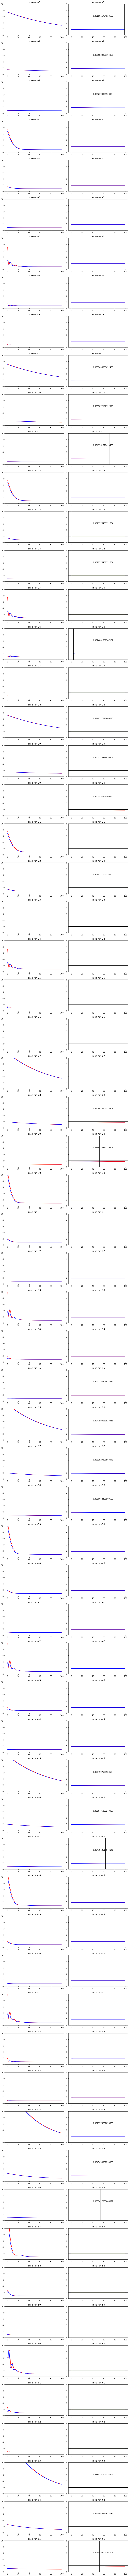

In [43]:
fig, axs = plt.subplots(ncols=2, nrows=len(run_history.keys()), figsize=(10, len(run_history.keys())*3))

for n, key in enumerate(run_history.keys()):
    axs[n,0].plot(run_history[key]['output'].history['loss'], color='r')
    axs[n,0].plot(run_history[key]['output'].history['val_loss'], color='b')
    
    axs[n,1].plot(run_history[key]['output'].history['root_mean_squared_error'], color='r')
    axs[n,1].plot(run_history[key]['output'].history['val_root_mean_squared_error'], color='b')
    
    try:
        axs[n,1].axvline(np.where(run_history[key]['output'].history['val_root_mean_squared_error']==np.min(run_history[key]['output'].history['val_root_mean_squared_error'])), 
                         color='k', lw=1)
        axs[n,1].annotate(str(np.min(run_history[key]['output'].history['val_root_mean_squared_error'])),
                            xy=(40,3),)
    except:
        pass
    
#     title_str = '-'.join(str(run_history[key]['params'][param]) for param in run_history[key]['params'].keys(),
#                         xytext=(.8,.8), xycoords='subfigure fraction')
    
    axs[n,0].set_title("mse {}".format(key))
    axs[n,1].set_title("rmse {}".format(key))
    
    axs[n,0].set_ylim(0,10)
    axs[n,1].set_ylim(0,5)
    
    axs[n, 1].axhline(1, color='k', lw=1)
    
plt.tight_layout()   
plt.show()

In [ ]:
print(run_history['run-0'])
print(run_history['run-1'])
# print(run_history['run-2'])
# print(run_history['run-3'])
# print(run_history['run-6'])

In [ ]:
X_train

In [ ]:
X_train.groupby('user').count().sort_values(by='movie',ascending=False).head()

In [ ]:
user = 31060
ratings[ratings.user==user]

In [ ]:
movie_array = ratings[ratings.user==user].movie.values.astype(int)
user = np.array([int(user) for n in range(len(movie_array))])

In [ ]:
pred = model.predict([movie_array, user])

In [ ]:
def is_close_enough(pred, ratings):
    val = []
    for pair in zip(pred, ratings):
        if pair[1] == 5:
            val.append(pair[1] - 1 <= pair[0])
        elif pair[1] == 1:
            val.append(pair[1] + 1 <= pair[0])
        else:
            val.append(pair[1] - .5 <= pair[0] <= pair[1] + .5)
        
    return sum(val) / len(pred.flatten())

In [ ]:
is_close_enough(np.round(pred.flatten(), 1), ratings[ratings.user_id==user_id].rating_score.values)

In [ ]:
stats = []
for u in X_train.user.unique():
    movie_array = ratings[ratings.user==u].movie.values.astype(int)
    user_array = np.array([int(u) for n in range(len(movie_array))])
    pred = model.predict([movie_array, user_array])
    
    acc = is_close_enough(np.round(pred.flatten(), 1), X_train[X_train.user==u].rating_score.values)
    
    stats.append((u, acc, len(movie_array), np.mean(X_train[X_train.user==u].rating_score.values)))

In [ ]:
len(stats)

In [ ]:
stats[-1]

In [ ]:
stats_df = pd.DataFrame(stats, columns=['user', 'accuracy', 'n_ratings', 'mean_rating'])
stats_df

In [ ]:
fig, ax = plt.subplots()

sns.scatterplot(data=stats_df, x='mean_rating', y='accuracy')

plt.show()

In [ ]:
fig, ax = plt.subplots()

sns.scatterplot(data=stats_df, x='n_ratings', y='accuracy')

plt.show()

In [ ]:
sns.histplot(data=stats_df, x='accuracy')

plt.show()

In [ ]:
import json
def export_history(run_history, batch_size, n_epochs, save_path):
    history_dict = run_history.copy()
    for key in history_dict:
        if history_dict[key]['params']['HP_REGULARIZER']=='l2':
            
            history_dict[key]['params']['HP_REGULARIZER'] = .01
        else:
            try:
                history_dict[key]['params']['HP_REGULARIZER'] = history_dict[key]['params']['HP_REGULARIZER'].l2.tolist()
            except:
                pass   
        if type(history_dict[key]['params']['HP_REGULARIZER']) == np.ndarray:
            history_dict[key]['params']['HP_REGULARIZER'] = history_dict[key]['params']['HP_REGULARIZER'].tolist()
        history_dict[key]['params']['batch_size'] = batch_size
        history_dict[key]['params']['n_epochs'] = n_epochs
        
        try:
            history_dict[key]['output'] = history_dict[key]['output'].history
        except:
            history_dict[key]['output'] = history_dict[key]['output']
      
    with open(save_path, 'w') as f:
        json.dump(history_dict, f)
    
    return history_dict

new_dict = export_history(run_history, len(X_train), 100, "./run_history/model7.json")